  # Metrics for hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

  ### Definition of names for plots and files

In [2]:
morethan5 = False

extragalactic = False
galactic = False

date = '2020609'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.1.csv'

features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'



#features_file = '../ZTF_data/features_20200109_phot_corrected_withWISE_withSNfeat_withMHPScorrected.csv'


class_output = '../ZTF_classifications/classification_unlabelled_set_with_TSvs5_20191119.csv'


### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_feat_for_stats = df_feat.copy()
print(df_labels['class_source'].values.size)
print(df_feat.head())

173879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['classALeRCE'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[df_labels['source']!="ASASSN"]

df_labels = df_labels[(df_labels['class_source']!="ELL")]

bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']



df_labels.drop(bad_oid,inplace=True)

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova','LPV',
               'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']


labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[(labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']

cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(173041,)


,class_original,class_hierachical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

123496
123496
123496
123496


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aapcxhy,0.068704,0.052665,0.665183,0.501831,1.0,1.0,0.250000,0.307692,0.0,0.0,...,0.780000,0.013542,0.796,2.889,8.106832,5.217832,8.668390,5.779390,0.202128,1.155121
ZTF18abtmwvo,0.115177,-999.000000,0.996398,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.717857,0.216488,0.807,2.964,-999.000000,-999.000000,9.126021,6.162021,0.081005,-999.000000
ZTF18acvgdfy,0.050608,-999.000000,0.353987,-999.000000,1.0,-999.0,0.500000,-999.000000,0.0,-999.0,...,0.683333,0.088542,0.606,2.876,-999.000000,-999.000000,8.483215,5.607215,0.023222,-999.000000
ZTF19aabvjsi,-999.000000,0.028547,-999.000000,0.494246,-999.0,1.0,-999.000000,0.333333,-999.0,0.0,...,0.683333,0.035875,0.938,3.017,8.099364,5.082364,-999.000000,-999.000000,-999.000000,0.529107
ZTF18aadyxlg,-999.000000,0.021935,-999.000000,0.543918,-999.0,1.0,-999.000000,0.500000,-999.0,0.0,...,0.683333,0.161542,0.959,3.021,8.041334,5.020334,-999.000000,-999.000000,-999.000000,0.277404


In [6]:
print(df.columns)

Index(['Amplitude_1', 'Amplitude_2', 'AndersonDarling_1', 'AndersonDarling_2',
       'Autocor_length_1', 'Autocor_length_2', 'Beyond1Std_1', 'Beyond1Std_2',
       'Con_1', 'Con_2',
       ...
       'rb', 'sgscore1', 'W1-W2', 'W2-W3', 'r-W3', 'r-W2', 'g-W3', 'g-W2',
       'delta_period_1', 'delta_period_2'],
      dtype='object', length=152)


In [7]:
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1272
SNIbc 94
SNII 328
SLSN 24
QSO 26168
AGN 4667
Blazar 1267
YSO 1740
CV/Nova 871
LPV 14076
E 37901
DSCT 732
RRL 32482
CEP 618
Periodic-Other 1256


  ### Defining functions to plot the confusion matrix and the feature importance

In [8]:
def plot_confusion_matrix(cm,cm_low,cm_high, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues,font=20,fig_x = 20, fig_y = 12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm_aux = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_low = np.round((cm_low.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm_high = np.round((cm_high.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        cm = cm_aux
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = font+1)
    plt.yticks(tick_marks, classes, fontsize = font+1)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #plt.text(j, i, format(cm[i, j], fmt),
        if cm_high[i, j]>100: cm_high[i, j]=100
        plt.text(j, i,r"$%d^{+%d}_{-%d}$"%  (cm[i, j],cm_high[i, j]-cm[i, j],cm[i, j]-cm_low[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = font)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = font+2)
    plt.xlabel('Predicted label',fontsize = font+2)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [9]:
def compute_accuracy_periodic_transient_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        
            
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]     
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII")  | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII")  | (pred_y_AQB=="SLSN"))]="SN"
            
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"

            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
            
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='E']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        true_y_AGN[np.where((true_y_AGN!="E"))]="Other"
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        pred_y_AGN[np.where((pred_y_AGN!="E"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="E")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='CEP']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="CEP"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="CEP"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="CEP")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]

    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [10]:
def compute_accuracy_stochastic_1band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        
        
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class

    acc_mag_1band_AQB=[]    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''        
        
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]

        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
            
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        #print("True AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)
        

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''



        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)        
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [11]:
def compute_accuracy_stochastic_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        #print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #AGN+QSO+Blazar
        
        df_test_1band_aux_AQB = df_test_1band_aux[(df_test_1band_aux['class_original']=='AGN') | (df_test_1band_aux['class_original']=='QSO') | (df_test_1band_aux['class_original']=='Blazar')]
        true_y_AQB = df_test_1band_aux_AQB['class_original'].values
        true_y_AQB[np.where((true_y_AQB=="AGN") |(true_y_AQB=="QSO") | (true_y_AQB=="Blazar"))]="AQB"
        pred_y_AQB = df_test_1band_aux_AQB['predicted_class'].values
        pred_y_AQB[np.where((pred_y_AQB=="AGN") |(pred_y_AQB=="QSO") | (pred_y_AQB=="Blazar"))]="AQB"
        true_y_AQB[np.where((true_y_AQB!="AQB"))]="Other"
        pred_y_AQB[np.where((pred_y_AQB!="AQB"))]="Other"
        acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="AQB")
        nsamples_AQB = len(pred_y_AQB)
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='AGN']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="AGN"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="AGN"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="AGN")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='QSO']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="QSO"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="QSO"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="QSO")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='Blazar']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="Blazar"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="Blazar"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="Blazar")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='LPV']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="LPV"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="LPV"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="LPV")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='YSO']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="YSO"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="YSO"))]="Other"
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="YSO")
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        
        #Cv/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='CV/Nova']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        true_y_CV[np.where((true_y_CV!="CV/Nova"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="CV/Nova"))]="Other"
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="CV/Nova")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)



In [12]:
def compute_accuracy_periodic_transient_2band(min_bin,max_bin,dbin,feature,X_test_hierarchical_gr,original_class,predicted_class):
    bins_mag = np.arange(min_bin,max_bin,dbin)
    
    df_test_1band = X_test_hierarchical_gr.copy()
    df_test_1band['class_original'] = original_class
    df_test_1band['predicted_class'] = predicted_class
    
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    #'''
    if 'n_det' in feature: 
        
        bins_mag = np.logspace(np.log10(min_bin),np.log10(max_bin),dbin, base=10.0,endpoint=True)
        #bins_mag = np.power(10,bins_mag)
        print(bins_mag)
        
        #df_test_1band['tot_n_det'] = df_test_1band['n_det_1']+df_test_1band['n_det_2']
        #feature = 'tot_n_det'
    #'''
    
    acc_mag_1band_AQB=[]
    acc_mag_1band_AGN=[]
    acc_mag_1band_QSO=[]
    acc_mag_1band_Blazar=[]
    acc_mag_1band_LPV=[]
    acc_mag_1band_YSO=[]
    acc_mag_1band_CV=[]
    
    nsamp_mag_1band_AQB=[]
    nsamp_mag_1band_AGN=[]
    nsamp_mag_1band_QSO=[]
    nsamp_mag_1band_Blazar=[]
    nsamp_mag_1band_LPV=[]
    nsamp_mag_1band_YSO=[]
    nsamp_mag_1band_CV=[]
    
    
    for i in range(len(bins_mag)-1):
        #'''
        if 'n_det' in feature:
            
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i])) & (df_test_1band[feature]<(bins_mag[i+1])))]
            
        else:    
            df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        #'''
        #df_test_1band_aux = df_test_1band[((df_test_1band[feature]>=(bins_mag[i]-dbin*0.5)) & (df_test_1band[feature]<(bins_mag[i]+dbin*0.5)))]
        
        #Transients (all together)
        

        #df_test_1band_aux_AQB = df_test_1band_aux.iloc[(np.flatnonzero(np.core.defchararray.find(df_test_1band_aux['class_original'].values,"SN")!=-1)),:]                                                                                           
        df_test_1band_aux_AQB = df_test_1band_aux[df_test_1band_aux['class_original'].str.contains("SN")]            
        true_y_AQB = np.array(df_test_1band_aux_AQB['class_original'].values)
        if len(true_y_AQB)>0:
            true_y_AQB[np.where((true_y_AQB=="SNIa") |(true_y_AQB=="SNIbc") | (true_y_AQB=="SNII") | (true_y_AQB=="SLSN"))]="SN"
            pred_y_AQB = np.array(df_test_1band_aux_AQB['predicted_class'].values)
            pred_y_AQB[np.where((pred_y_AQB=="SNIa") |(pred_y_AQB=="SNIbc") | (pred_y_AQB=="SNII") | (pred_y_AQB=="SLSN"))]="SN"
            true_y_AQB[np.where((true_y_AQB!="SN"))]="Other"
            pred_y_AQB[np.where((pred_y_AQB!="SN"))]="Other"
            acc_AQB = metrics.recall_score(true_y_AQB, pred_y_AQB,pos_label="SN")
            nsamples_AQB = len(pred_y_AQB)
        else: 
            nsamples_AQB = 0
            acc_AQB = np.nan
        nsamp_mag_1band_AQB.append(nsamples_AQB)
        acc_mag_1band_AQB.append(acc_AQB)
        
        
        #AGN:
        df_test_1band_aux_AGN = df_test_1band_aux[df_test_1band_aux['class_original']=='E']
        true_y_AGN = df_test_1band_aux_AGN['class_original'].values
        pred_y_AGN = df_test_1band_aux_AGN['predicted_class'].values
        true_y_AGN[np.where((true_y_AGN!="E"))]="Other"
        pred_y_AGN[np.where((pred_y_AGN!="E"))]="Other"
        acc_AGN = metrics.recall_score(true_y_AGN, pred_y_AGN,pos_label="E")
        nsamples_AGN = len(pred_y_AGN)
        nsamp_mag_1band_AGN.append(nsamples_AGN)
        acc_mag_1band_AGN.append(acc_AGN)
        #print("true AGN",true_y_AGN)
        #print("pred AGN",pred_y_AGN)

        #QSO:
        df_test_1band_aux_QSO = df_test_1band_aux[df_test_1band_aux['class_original']=='DSCT']
        true_y_QSO = df_test_1band_aux_QSO['class_original'].values
        pred_y_QSO = df_test_1band_aux_QSO['predicted_class'].values
        true_y_QSO[np.where((true_y_QSO!="DSCT"))]="Other"
        pred_y_QSO[np.where((pred_y_QSO!="DSCT"))]="Other"
        acc_QSO = metrics.recall_score(true_y_QSO, pred_y_QSO,pos_label="DSCT")
        nsamples_QSO = len(pred_y_QSO)
        acc_mag_1band_QSO.append(acc_QSO)
        nsamp_mag_1band_QSO.append(nsamples_QSO)
        '''
        print("True QSO",bins_mag[i],bins_mag[i+1],len(true_y_QSO))
        print("pred QSO",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]))
        print("pred AGN",bins_mag[i],bins_mag[i+1],len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]))
        print("pred qso+agn", len(pred_y_QSO[np.where(pred_y_QSO=='QSO')]) + len(pred_y_QSO[np.where(pred_y_QSO=='AGN')]) )
        '''

        #Blazar:
        df_test_1band_aux_Blazar = df_test_1band_aux[df_test_1band_aux['class_original']=='RRL']
        true_y_Blazar = df_test_1band_aux_Blazar['class_original'].values
        pred_y_Blazar = df_test_1band_aux_Blazar['predicted_class'].values
        true_y_Blazar[np.where((true_y_Blazar!="RRL"))]="Other"
        pred_y_Blazar[np.where((pred_y_Blazar!="RRL"))]="Other"
        acc_Blazar = metrics.recall_score(true_y_Blazar, pred_y_Blazar,pos_label="RRL")
        nsamples_Blazar = len(pred_y_Blazar)
        acc_mag_1band_Blazar.append(acc_Blazar)
        nsamp_mag_1band_Blazar.append(nsamples_Blazar)
        
        #LPV:
        df_test_1band_aux_LPV = df_test_1band_aux[df_test_1band_aux['class_original']=='CEP']
        true_y_LPV = df_test_1band_aux_LPV['class_original'].values
        pred_y_LPV = df_test_1band_aux_LPV['predicted_class'].values
        true_y_LPV[np.where((true_y_LPV!="CEP"))]="Other"
        pred_y_LPV[np.where((pred_y_LPV!="CEP"))]="Other"
        acc_LPV = metrics.recall_score(true_y_LPV, pred_y_LPV,pos_label="CEP")
        nsamples_LPV = len(pred_y_LPV)
        acc_mag_1band_LPV.append(acc_LPV)
        nsamp_mag_1band_LPV.append(nsamples_LPV)
        
        #YSO:
        '''
        df_test_1band_aux_YSO = df_test_1band_aux[df_test_1band_aux['class_original']=='RSCVn']
        true_y_YSO = df_test_1band_aux_YSO['class_original'].values
        pred_y_YSO = df_test_1band_aux_YSO['predicted_class'].values
        true_y_YSO[np.where((true_y_YSO!="RSCVn"))]="Other"
        pred_y_YSO[np.where((pred_y_YSO!="RSCVn"))]="Other"
        print("bin ",bins_mag[i])
        print("true RSCVn", true_y_YSO)
        print("pred RSCVn", pred_y_YSO)
        acc_YSO = metrics.recall_score(true_y_YSO, pred_y_YSO,pos_label="RSCVn")
        print("acc", acc_YSO)
        nsamples_YSO = len(pred_y_YSO)
        acc_mag_1band_YSO.append(acc_YSO)
        nsamp_mag_1band_YSO.append(nsamples_YSO)
        '''
        
        #CV/Nova:
        df_test_1band_aux_CV = df_test_1band_aux[df_test_1band_aux['class_original']=='Periodic-Other']
        true_y_CV = df_test_1band_aux_CV['class_original'].values
        pred_y_CV = df_test_1band_aux_CV['predicted_class'].values
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        true_y_CV[np.where((true_y_CV!="Periodic-Other"))]="Other"
        pred_y_CV[np.where((pred_y_CV!="Periodic-Other"))]="Other"
        #print(bins_mag[i])
        #print("true PO: ",true_y_CV)
        #print("pred PO: ",pred_y_CV)
        acc_CV = metrics.recall_score(true_y_CV, pred_y_CV,pos_label="Periodic-Other")
        nsamples_CV = len(pred_y_CV)
        acc_mag_1band_CV.append(acc_CV)
        nsamp_mag_1band_CV.append(nsamples_CV)
        
        
    acc_mag_1band_AQB = np.array(acc_mag_1band_AQB)
    acc_mag_1band_AGN = np.array(acc_mag_1band_AGN)
    acc_mag_1band_QSO = np.array(acc_mag_1band_QSO)
    acc_mag_1band_Blazar = np.array(acc_mag_1band_Blazar)
    acc_mag_1band_LPV = np.array(acc_mag_1band_LPV)
    #acc_mag_1band_YSO = np.array(acc_mag_1band_YSO)
    acc_mag_1band_CV = np.array(acc_mag_1band_CV)

    nsamp_mag_1band_AQB = np.array(nsamp_mag_1band_AQB)
    nsamp_mag_1band_AGN = np.array(nsamp_mag_1band_AGN)
    nsamp_mag_1band_QSO = np.array(nsamp_mag_1band_QSO)
    nsamp_mag_1band_Blazar = np.array(nsamp_mag_1band_Blazar)
    nsamp_mag_1band_LPV = np.array(nsamp_mag_1band_LPV)
    #nsamp_mag_1band_YSO = np.array(nsamp_mag_1band_YSO)
    nsamp_mag_1band_CV = np.array(nsamp_mag_1band_CV)
    
    #print(acc_mag_1band_YSO)
    
    #'''
    if 'n_det' in feature:
        bins_mag = bins_mag[:-1] + np.diff(bins_mag)*0.5
    else: 
        bins_mag = bins_mag[:-1]
    #'''
    
    #return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_YSO,acc_mag_1band_YSO,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)
    return(bins_mag,nsamp_mag_1band_AQB,acc_mag_1band_AQB,nsamp_mag_1band_AGN,acc_mag_1band_AGN,nsamp_mag_1band_QSO,acc_mag_1band_QSO,nsamp_mag_1band_Blazar,acc_mag_1band_Blazar,nsamp_mag_1band_CV,acc_mag_1band_CV,nsamp_mag_1band_LPV,acc_mag_1band_LPV)





In [13]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df.copy()#.columns.values.tolist()
#X_hierarchical = X_hierarchical.drop(['n_det_1','n_det_2'])

#splitting training set
#X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
#Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2)
splitted_set = sss.split(X_hierarchical, Y_original)


rf_model_hierarchical = RandomForestClassifier(
                n_estimators=500,
                max_features='auto',
                max_depth=None,
                n_jobs=-1,
                bootstrap=True,
                class_weight='balanced_subsample',
                criterion='entropy',
                min_samples_split=2,
                min_samples_leaf=1)


rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            #bootstrap=False,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


ind = 0
list_Accuracy_first_layer = []
list_Balanced_Accuracy_first_layer = []
list_precision_first_layer = []
list_recall_first_layer = []
list_F1_Accuracy_first_layer = []

list_Accuracy_last_layer = []
list_Balanced_Accuracy_last_layer = []
list_precision_last_layer = []
list_recall_last_layer = []
list_F1_Accuracy_last_layer = []

list_cnf_matrix = []

list_cnf_matrix_hier = []

list_acc_mag_rband_AQB = []
list_acc_mag_rband_AGN = []
list_acc_mag_rband_QSO = []
list_acc_mag_rband_Blazar = []
list_acc_mag_rband_YSO = []
list_acc_mag_rband_CV = []
list_acc_mag_rband_LPV = []

list_acc_mag_gband_AQB = []
list_acc_mag_gband_AGN = []
list_acc_mag_gband_QSO = []
list_acc_mag_gband_Blazar = []
list_acc_mag_gband_YSO = []
list_acc_mag_gband_CV = []
list_acc_mag_gband_LPV = []

list_acc_nsamp_rband_AQB = []
list_acc_nsamp_rband_AGN = []
list_acc_nsamp_rband_QSO = []
list_acc_nsamp_rband_Blazar = []
list_acc_nsamp_rband_YSO = []
list_acc_nsamp_rband_CV = []
list_acc_nsamp_rband_LPV = []

list_acc_nsamp_gband_AQB = []
list_acc_nsamp_gband_AGN = []
list_acc_nsamp_gband_QSO = []
list_acc_nsamp_gband_Blazar = []
list_acc_nsamp_gband_YSO = []
list_acc_nsamp_gband_CV = []
list_acc_nsamp_gband_LPV = []

list_acc_mag_grband_AQB = []
list_acc_mag_grband_AGN = []
list_acc_mag_grband_QSO = []
list_acc_mag_grband_Blazar = []
list_acc_mag_grband_YSO = []
list_acc_mag_grband_CV = []
list_acc_mag_grband_LPV = []

list_acc_nsamp_grband_AQB = []
list_acc_nsamp_grband_AGN = []
list_acc_nsamp_grband_QSO = []
list_acc_nsamp_grband_Blazar = []
list_acc_nsamp_grband_YSO = []
list_acc_nsamp_grband_CV = []
list_acc_nsamp_grband_LPV = []

##

list_nsamp_mag_rband_AQB = []
list_nsamp_mag_rband_AGN = []
list_nsamp_mag_rband_QSO = []
list_nsamp_mag_rband_Blazar = []
list_nsamp_mag_rband_YSO = []
list_nsamp_mag_rband_CV = []
list_nsamp_mag_rband_LPV = []

list_nsamp_mag_gband_AQB = []
list_nsamp_mag_gband_AGN = []
list_nsamp_mag_gband_QSO = []
list_nsamp_mag_gband_Blazar = []
list_nsamp_mag_gband_YSO = []
list_nsamp_mag_gband_CV = []
list_nsamp_mag_gband_LPV = []

list_nsamp_nsamp_rband_AQB = []
list_nsamp_nsamp_rband_AGN = []
list_nsamp_nsamp_rband_QSO = []
list_nsamp_nsamp_rband_Blazar = []
list_nsamp_nsamp_rband_YSO = []
list_nsamp_nsamp_rband_CV = []
list_nsamp_nsamp_rband_LPV = []

list_nsamp_nsamp_gband_AQB = []
list_nsamp_nsamp_gband_AGN = []
list_nsamp_nsamp_gband_QSO = []
list_nsamp_nsamp_gband_Blazar = []
list_nsamp_nsamp_gband_YSO = []
list_nsamp_nsamp_gband_CV = []
list_nsamp_nsamp_gband_LPV = []

list_nsamp_mag_grband_AQB = []
list_nsamp_mag_grband_AGN = []
list_nsamp_mag_grband_QSO = []
list_nsamp_mag_grband_Blazar = []
list_nsamp_mag_grband_YSO = []
list_nsamp_mag_grband_CV = []
list_nsamp_mag_grband_LPV = []

list_nsamp_nsamp_grband_AQB = []
list_nsamp_nsamp_grband_AGN = []
list_nsamp_nsamp_grband_QSO = []
list_nsamp_nsamp_grband_Blazar = []
list_nsamp_nsamp_grband_YSO = []
list_nsamp_nsamp_grband_CV = []
list_nsamp_nsamp_grband_LPV = []

##

list_acc_mag_rband_transients = []
list_acc_mag_rband_EB = []
list_acc_mag_rband_DSCT = []
list_acc_mag_rband_RRL = []
list_acc_mag_rband_Ceph = []
#list_acc_mag_rband_RSCVn = []
list_acc_mag_rband_Other = []

list_acc_mag_gband_transients = []
list_acc_mag_gband_EB = []
list_acc_mag_gband_DSCT = []
list_acc_mag_gband_RRL = []
list_acc_mag_gband_Ceph = []
#list_acc_mag_gband_RSCVn = []
list_acc_mag_gband_Other = []

list_acc_nsamp_rband_transients = []
list_acc_nsamp_rband_EB = []
list_acc_nsamp_rband_DSCT = []
list_acc_nsamp_rband_RRL = []
list_acc_nsamp_rband_Ceph = []
#list_acc_nsamp_rband_RSCVn = []
list_acc_nsamp_rband_Other = []

list_acc_nsamp_gband_transients = []
list_acc_nsamp_gband_EB = []
list_acc_nsamp_gband_DSCT = []
list_acc_nsamp_gband_RRL = []
list_acc_nsamp_gband_Ceph = []
#list_acc_nsamp_gband_RSCVn = []
list_acc_nsamp_gband_Other = []

list_acc_mag_grband_transients = []
list_acc_mag_grband_EB = []
list_acc_mag_grband_DSCT = []
list_acc_mag_grband_RRL = []
list_acc_mag_grband_Ceph = []
#list_acc_mag_grband_RSCVn = []
list_acc_mag_grband_Other = []

list_acc_nsamp_grband_transients = []
list_acc_nsamp_grband_EB = []
list_acc_nsamp_grband_DSCT = []
list_acc_nsamp_grband_RRL = []
list_acc_nsamp_grband_Ceph = []
#list_acc_nsamp_grband_RSCVn = []
list_acc_nsamp_grband_Other = []

##

list_nsamp_mag_rband_transients = []
list_nsamp_mag_rband_EB = []
list_nsamp_mag_rband_DSCT = []
list_nsamp_mag_rband_RRL = []
list_nsamp_mag_rband_Ceph = []
#list_nsamp_mag_rband_RSCVn = []
list_nsamp_mag_rband_Other = []

list_nsamp_mag_gband_transients = []
list_nsamp_mag_gband_EB = []
list_nsamp_mag_gband_DSCT = []
list_nsamp_mag_gband_RRL = []
list_nsamp_mag_gband_Ceph = []
#list_nsamp_mag_gband_RSCVn = []
list_nsamp_mag_gband_Other = []

list_nsamp_nsamp_rband_transients = []
list_nsamp_nsamp_rband_EB = []
list_nsamp_nsamp_rband_DSCT = []
list_nsamp_nsamp_rband_RRL = []
list_nsamp_nsamp_rband_Ceph = []
#list_nsamp_nsamp_rband_RSCVn = []
list_nsamp_nsamp_rband_Other = []

list_nsamp_nsamp_gband_transients = []
list_nsamp_nsamp_gband_EB = []
list_nsamp_nsamp_gband_DSCT = []
list_nsamp_nsamp_gband_RRL = []
list_nsamp_nsamp_gband_Ceph = []
#list_nsamp_nsamp_gband_RSCVn = []
list_nsamp_nsamp_gband_Other = []

list_nsamp_mag_grband_transients = []
list_nsamp_mag_grband_EB = []
list_nsamp_mag_grband_DSCT = []
list_nsamp_mag_grband_RRL = []
list_nsamp_mag_grband_Ceph = []
#list_nsamp_mag_grband_RSCVn = []
list_nsamp_mag_grband_Other = []

list_nsamp_nsamp_grband_transients = []
list_nsamp_nsamp_grband_EB = []
list_nsamp_nsamp_grband_DSCT = []
list_nsamp_nsamp_grband_RRL = []
list_nsamp_nsamp_grband_Ceph = []
#list_nsamp_nsamp_grband_RSCVn = []
list_nsamp_nsamp_grband_Other = []

##



for train_index, test_index in splitted_set:
    print("iteration ", ind)
    X_train_hierarchical, X_test_hierarchical = X_hierarchical.iloc[train_index], X_hierarchical.iloc[test_index]
    y_train_original, y_test_original = Y_original.iloc[train_index], Y_original.iloc[test_index]
    y_train_hierarchical, y_test_hierarchical = Y_hierarchical.iloc[train_index], Y_hierarchical.iloc[test_index]
    
    X_test_hierarchical_for_stats = X_test_hierarchical.copy()
    X_test_hierarchical_for_stats = X_test_hierarchical_for_stats.join(df_feat_for_stats.loc[:,['n_det_1','n_det_2']],how='left')
    
    
    # separating training sets for sub-classes
    X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
    #X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
    y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

    X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
    y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

    X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
    #X_train_transient.drop(['Mean_2'], axis=1,inplace=True)
    y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

    #X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

    X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    #X_test_hierarchical = X_test_hierarchical#.drop(['Mean_2'], axis=1)
    
    print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))
    
    #Training first layer of the RF model

    #print(X_train_hierarchical)
    #print(y_train_hierarchical)
    rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

    #testing first layer performance

    y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
    y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

    classes_order_proba_hierarchical = rf_model_hierarchical.classes_

    acc_h = metrics.accuracy_score(y_true, y_pred)
    balandec_acc_h = metrics.balanced_accuracy_score(y_true, y_pred)
    pres_h = metrics.precision_score(y_true, y_pred, average='macro')
    rec_h = metrics.recall_score(y_true, y_pred, average='macro')
    f1_h = metrics.f1_score(y_true, y_pred, average='macro')
    
    list_Accuracy_first_layer.append(acc_h)
    list_Balanced_Accuracy_first_layer.append(balandec_acc_h)
    list_precision_first_layer.append(pres_h)
    list_recall_first_layer.append(rec_h)
    list_F1_Accuracy_first_layer.append(f1_h)
    
    print("macro F1:", acc_h)
    print("Balanced accuracy:", balandec_acc_h)
    
    cnf_matrix_hier = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
    print(cnf_matrix_hier)
    list_cnf_matrix_hier.append(cnf_matrix_hier)
    #Training Periodic layer
    rf_model_periodic.fit(X_train_periodic, y_train_periodic)

    # Applying periodic model to the test data
    y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
    y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)
    
    classes_order_proba_periodic = rf_model_periodic.classes_
    
    #Training Stochastic layer
    rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)

    # Applying stochastic model to the test data
    y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
    y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)
    
    classes_order_proba_stochastic = rf_model_stochastic.classes_
    
    #Training Transient layer
    rf_model_transient.fit(X_train_transient, y_train_transient)

    # Applying transient model to the test data
    y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
    y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

    classes_order_proba_transient = rf_model_transient.classes_
    
    # generating final probabilities

    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

    print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

    #getting the ordered name of classes for prob_final
    prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
    print(prob_final_class_names)


    class_final_proba = np.amax(prob_final,axis=1)
    class_final_index = np.argmax(prob_final,axis=1)
    class_final_name = [prob_final_class_names[x] for x in class_final_index]
    
    class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])
    
    cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
    #print(cnf_matrix)
    list_cnf_matrix.append(cnf_matrix)
    
    acc = metrics.accuracy_score(y_test_original, class_final_name)
    balanced_acc = metrics.balanced_accuracy_score(y_test_original, class_final_name)
    pres = metrics.precision_score(y_test_original, class_final_name, average='macro')
    rec = metrics.recall_score(y_test_original, class_final_name, average='macro')
    f1 = metrics.f1_score(y_test_original, class_final_name, average='macro')
    
    list_Accuracy_last_layer.append(acc)
    list_Balanced_Accuracy_last_layer.append(balanced_acc)
    list_precision_last_layer.append(pres)
    list_recall_last_layer.append(rec)
    list_F1_Accuracy_last_layer.append(f1)
    
    print("Accuracy:", acc)
    print("Balanced accuracy:", balanced_acc)
    print("macro precision: ", pres)
    print("macro recall: ", rec)
    print("macro F1: ", f1)
    
    
    #####
    #####
    
    #balanced accuracy curves
    
    #selecting sources with info in both bands
    X_test_hierarchical_gr = X_test_hierarchical_for_stats.join(df_feat[['Mean_1','Mean_2']],how='left')

    X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['n_det_1']>5) & (X_test_hierarchical_gr['n_det_2']>5)]
    y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]
    y_test_hierarchical_gr = y_test_hierarchical[X_test_hierarchical_gr.index]
    class_final_name_gr = class_final_name_df.loc[X_test_hierarchical_gr.index]
    
    print(len(X_test_hierarchical_gr.columns),len(y_test_original_gr),len(y_test_hierarchical_gr))

    #stochastics
    bins_mag_gr,nsamples_AQB,acc_mag_grband_AQB,nsamples_AGN,acc_mag_grband_AGN,nsamples_QSO,acc_mag_grband_QSO,nsamples_Blazar,acc_mag_grband_Blazar,nsamples_YSO,acc_mag_grband_YSO,nsamples_CV,acc_mag_grband_CV,nsamples_LPV,acc_mag_grband_LPV = compute_accuracy_stochastic_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_AQB,acc_nsamp_grband_AQB,nsamp_nsamples_AGN,acc_nsamp_grband_AGN,nsamp_nsamples_QSO,acc_nsamp_grband_QSO,nsamp_nsamples_Blazar,acc_nsamp_grband_Blazar,nsamp_nsamples_YSO,acc_nsamp_grband_YSO,nsamp_nsamples_CV,acc_nsamp_grband_CV,nsamp_nsamples_LPV,acc_nsamp_grband_LPV = compute_accuracy_stochastic_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)

    #periodic+transients
    bins_mag_gr,nsamples_transients,acc_mag_grband_transients,nsamples_EB,acc_mag_grband_EB,nsamples_DSCT,acc_mag_grband_DSCT,nsamples_RRL,acc_mag_grband_RRL,nsamples_Other,acc_mag_grband_Other,nsamples_Ceph,acc_mag_grband_Ceph = compute_accuracy_periodic_transient_2band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)
    bins_nsamp_gr,nsamp_nsamples_transients,acc_nsamp_grband_transients,nsamp_nsamples_EB,acc_nsamp_grband_EB,nsamp_nsamples_DSCT,acc_nsamp_grband_DSCT,nsamp_nsamples_RRL,acc_nsamp_grband_RRL,nsamp_nsamples_Other,acc_nsamp_grband_Other,nsamp_nsamples_Ceph,acc_nsamp_grband_Ceph = compute_accuracy_periodic_transient_2band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_gr)


    r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
    g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='Mean_1') or (f=='Mean_2') or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]

    #####
    
    #modelling just with g band
    X_test_hierarchical_g = X_test_hierarchical_gr.copy()
    X_test_hierarchical_g[r_feat] = -999
    X_test_hierarchical_g = X_test_hierarchical_g.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_g, y_pred_g = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_g)
    y_pred_proba_hier_g = rf_model_hierarchical.predict_proba(X_test_hierarchical_g)
    
    y_true_periodic_g, y_pred_periodic_g = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_g)
    y_pred_proba_periodic_g = rf_model_periodic.predict_proba(X_test_hierarchical_g)
    
    y_true_stochastic_g, y_pred_stochastic_g  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_g)
    y_pred_proba_stochastic_g = rf_model_stochastic.predict_proba(X_test_hierarchical_g)
    
    y_true_transient_g, y_pred_transient_g  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_g)
    y_pred_proba_transient_g = rf_model_transient.predict_proba(X_test_hierarchical_g)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_g = y_pred_proba_periodic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_g = y_pred_proba_stochastic_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_g = y_pred_proba_transient_g*y_pred_proba_hier_g[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_g = np.concatenate((prob_stochastic_g,prob_trainsient_g,prob_periodic_g),axis=1)

    print(np.sum(prob_final_g,axis=1),np.mean(np.sum(prob_final_g,axis=1)),np.std(np.sum(prob_final_g,axis=1)))

    #getting prob_final

    class_final_proba_g = np.amax(prob_final_g,axis=1)
    class_final_index_g = np.argmax(prob_final_g,axis=1)
    class_final_name_g = [prob_final_class_names[x] for x in class_final_index_g]
    
    #computing acc:
    #stochastics
    print("G BAND ######")
    bins_mag_g,nsamples_AQB_g,acc_mag_gband_AQB,nsamples_AGN_g,acc_mag_gband_AGN,nsamples_QSO_g,acc_mag_gband_QSO,nsamples_Blazar_g,acc_mag_gband_Blazar,nsamples_YSO_g,acc_mag_gband_YSO,nsamples_CV_g,acc_mag_gband_CV,nsamples_LPV_g,acc_mag_gband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_AQB_g,acc_nsamp_gband_AQB,nsamp_nsamples_AGN_g,acc_nsamp_gband_AGN,nsamp_nsamples_QSO_g,acc_nsamp_gband_QSO,nsamp_nsamples_Blazar_g,acc_nsamp_gband_Blazar,nsamp_nsamples_YSO_g,acc_nsamp_gband_YSO,nsamp_nsamples_CV_g,acc_nsamp_gband_CV,nsamp_nsamples_LPV_g,acc_nsamp_gband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)

    #periodic+transients
    bins_mag_g,nsamples_transients_g,acc_mag_gband_transients,nsamples_EB_g,acc_mag_gband_EB,nsamples_DSCT_g,acc_mag_gband_DSCT,nsamples_RRL_g,acc_mag_gband_RRL,nsamples_Other_g,acc_mag_gband_Other,nsamples_Ceph_g,acc_mag_gband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)
    bins_nsamp_g,nsamp_nsamples_transients_g,acc_nsamp_gband_transients,nsamp_nsamples_EB_g,acc_nsamp_gband_EB,nsamp_nsamples_DSCT_g,acc_nsamp_gband_DSCT,nsamp_nsamples_RRL_g,acc_nsamp_gband_RRL,nsamp_nsamples_Other_g,acc_nsamp_gband_Other,nsamp_nsamples_Ceph_g,acc_nsamp_gband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_1',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_g)


    
    print(acc_mag_gband_AGN,acc_nsamp_gband_AGN)

    #####
    
    #modelling just with r band
    X_test_hierarchical_r = X_test_hierarchical_gr.copy()
    X_test_hierarchical_r[g_feat] = -999
    X_test_hierarchical_r = X_test_hierarchical_r.drop(['Mean_1','Mean_2','n_det_1','n_det_2'],axis=1)


    
    y_true_r, y_pred_r = y_test_hierarchical_gr, rf_model_hierarchical.predict(X_test_hierarchical_r)
    y_pred_proba_hier_r = rf_model_hierarchical.predict_proba(X_test_hierarchical_r)
    
    y_true_periodic_r, y_pred_periodic_r = y_test_original_gr, rf_model_periodic.predict(X_test_hierarchical_r)
    y_pred_proba_periodic_r = rf_model_periodic.predict_proba(X_test_hierarchical_r)
    
    y_true_stochastic_r, y_pred_stochastic_r  = y_test_original_gr, rf_model_stochastic.predict(X_test_hierarchical_r)
    y_pred_proba_stochastic_r = rf_model_stochastic.predict_proba(X_test_hierarchical_r)
    
    y_true_transient_r, y_pred_transient_r  = y_test_original_gr, rf_model_transient.predict(X_test_hierarchical_r)
    y_pred_proba_transient_r = rf_model_transient.predict_proba(X_test_hierarchical_r)
    
    #multiplying probabilities of the hierarchical layer with the other layers
    prob_periodic_r = y_pred_proba_periodic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
    prob_stochastic_r = y_pred_proba_stochastic_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
    prob_trainsient_r = y_pred_proba_transient_r*y_pred_proba_hier_r[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

    #obtaining final probabilities matrix
    prob_final_r = np.concatenate((prob_stochastic_r,prob_trainsient_r,prob_periodic_r),axis=1)

    print(np.sum(prob_final_r,axis=1),np.mean(np.sum(prob_final_r,axis=1)),np.std(np.sum(prob_final_r,axis=1)))

    #getting  prob_final
    class_final_proba_r = np.amax(prob_final_r,axis=1)
    class_final_index_r = np.argmax(prob_final_r,axis=1)
    class_final_name_r = [prob_final_class_names[x] for x in class_final_index_r]
    
    #computing acc:
    #stochastics
    print("R BAND ######")
    bins_mag_r,nsamples_AQB_r,acc_mag_rband_AQB,nsamples_AGN_r,acc_mag_rband_AGN,nsamples_QSO_r,acc_mag_rband_QSO,nsamples_Blazar_r,acc_mag_rband_Blazar,nsamples_YSO_r,acc_mag_rband_YSO,nsamples_CV_r,acc_mag_rband_CV,nsamples_LPV_r,acc_mag_rband_LPV = compute_accuracy_stochastic_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_AQB_r,acc_nsamp_rband_AQB,nsamp_nsamples_AGN_r,acc_nsamp_rband_AGN,nsamp_nsamples_QSO_r,acc_nsamp_rband_QSO,nsamp_nsamples_Blazar_r,acc_nsamp_rband_Blazar,nsamp_nsamples_YSO_r,acc_nsamp_rband_YSO,nsamp_nsamples_CV_r,acc_nsamp_rband_CV,nsamp_nsamples_LPV_r,acc_nsamp_rband_LPV = compute_accuracy_stochastic_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)

    #periodic+transients
    bins_mag_r,nsamples_transients_r,acc_mag_rband_transients,nsamples_EB_r,acc_mag_rband_EB,nsamples_DSCT_r,acc_mag_rband_DSCT,nsamples_RRL_r,acc_mag_rband_RRL,nsamples_Other_r,acc_mag_rband_Other,nsamples_Ceph_r,acc_mag_rband_Ceph = compute_accuracy_periodic_transient_1band(13,22.1,0.5,'Mean_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)
    bins_nsamp_r,nsamp_nsamples_transients_r,acc_nsamp_rband_transients,nsamp_nsamples_EB_r,acc_nsamp_rband_EB,nsamp_nsamples_DSCT_r,acc_nsamp_rband_DSCT,nsamp_nsamples_RRL_r,acc_nsamp_rband_RRL,nsamp_nsamples_Other_r,acc_nsamp_rband_Other,nsamp_nsamples_Ceph_r,acc_nsamp_rband_Ceph = compute_accuracy_periodic_transient_1band(6,501,15,'n_det_2',X_test_hierarchical_gr,y_test_original_gr.values,class_final_name_r)


    list_acc_mag_rband_AQB.append(acc_mag_rband_AQB)
    list_acc_mag_rband_AGN.append(acc_mag_rband_AGN)
    list_acc_mag_rband_QSO.append(acc_mag_rband_QSO)
    list_acc_mag_rband_Blazar.append(acc_mag_rband_Blazar)
    list_acc_mag_rband_YSO.append(acc_mag_rband_YSO)
    list_acc_mag_rband_CV.append(acc_mag_rband_CV)
    list_acc_mag_rband_LPV.append(acc_mag_rband_LPV)

    list_acc_mag_gband_AQB.append(acc_mag_gband_AQB)
    list_acc_mag_gband_AGN.append(acc_mag_gband_AGN)
    list_acc_mag_gband_QSO.append(acc_mag_gband_QSO)
    list_acc_mag_gband_Blazar.append(acc_mag_gband_Blazar)
    list_acc_mag_gband_YSO.append(acc_mag_gband_YSO)
    list_acc_mag_gband_CV.append(acc_mag_gband_CV)
    list_acc_mag_gband_LPV.append(acc_mag_gband_LPV)

    list_acc_nsamp_rband_AQB.append(acc_nsamp_rband_AQB)
    list_acc_nsamp_rband_AGN.append(acc_nsamp_rband_AGN)
    list_acc_nsamp_rband_QSO.append(acc_nsamp_rband_QSO)
    list_acc_nsamp_rband_Blazar.append(acc_nsamp_rband_Blazar)
    list_acc_nsamp_rband_YSO.append(acc_nsamp_rband_YSO)
    list_acc_nsamp_rband_CV.append(acc_nsamp_rband_CV)
    list_acc_nsamp_rband_LPV.append(acc_nsamp_rband_LPV)

    list_acc_nsamp_gband_AQB.append(acc_nsamp_gband_AQB)
    list_acc_nsamp_gband_AGN.append(acc_nsamp_gband_AGN)
    list_acc_nsamp_gband_QSO.append(acc_nsamp_gband_QSO)
    list_acc_nsamp_gband_Blazar.append(acc_nsamp_gband_Blazar)
    list_acc_nsamp_gband_YSO.append(acc_nsamp_gband_YSO)
    list_acc_nsamp_gband_CV.append(acc_nsamp_gband_CV)
    list_acc_nsamp_gband_LPV.append(acc_nsamp_gband_LPV)

    list_acc_mag_grband_AQB.append(acc_mag_grband_AQB)
    list_acc_mag_grband_AGN.append(acc_mag_grband_AGN)
    list_acc_mag_grband_QSO.append(acc_mag_grband_QSO)
    list_acc_mag_grband_Blazar.append(acc_mag_grband_Blazar)
    list_acc_mag_grband_YSO.append(acc_mag_grband_YSO)
    list_acc_mag_grband_CV.append(acc_mag_grband_CV)
    list_acc_mag_grband_LPV.append(acc_mag_grband_LPV)

    list_acc_nsamp_grband_AQB.append(acc_nsamp_grband_AQB)
    list_acc_nsamp_grband_AGN.append(acc_nsamp_grband_AGN)
    list_acc_nsamp_grband_QSO.append(acc_nsamp_grband_QSO)
    list_acc_nsamp_grband_Blazar.append(acc_nsamp_grband_Blazar)
    list_acc_nsamp_grband_YSO.append(acc_nsamp_grband_YSO)
    list_acc_nsamp_grband_CV.append(acc_nsamp_grband_CV)
    list_acc_nsamp_grband_LPV.append(acc_nsamp_grband_LPV)


    ##
    
    list_nsamp_mag_rband_AQB.append(nsamples_AQB_r)
    list_nsamp_mag_rband_AGN.append(nsamples_AGN_r)
    list_nsamp_mag_rband_QSO.append(nsamples_QSO_r)
    list_nsamp_mag_rband_Blazar.append(nsamples_Blazar_r)
    list_nsamp_mag_rband_YSO.append(nsamples_YSO_r)
    list_nsamp_mag_rband_CV.append(nsamples_CV_r)
    list_nsamp_mag_rband_LPV.append(nsamples_LPV_r)

    list_nsamp_mag_gband_AQB.append(nsamples_AQB_g)
    list_nsamp_mag_gband_AGN.append(nsamples_AGN_g)
    list_nsamp_mag_gband_QSO.append(nsamples_QSO_g)
    list_nsamp_mag_gband_Blazar.append(nsamples_Blazar_g)
    list_nsamp_mag_gband_YSO.append(nsamples_YSO_g)
    list_nsamp_mag_gband_CV.append(nsamples_CV_g)
    list_nsamp_mag_gband_LPV.append(nsamples_LPV_g)

    list_nsamp_nsamp_rband_AQB.append(nsamp_nsamples_AQB_r)
    list_nsamp_nsamp_rband_AGN.append(nsamp_nsamples_AGN_r)
    list_nsamp_nsamp_rband_QSO.append(nsamp_nsamples_QSO_r)
    list_nsamp_nsamp_rband_Blazar.append(nsamp_nsamples_Blazar_r)
    list_nsamp_nsamp_rband_YSO.append(nsamp_nsamples_YSO_r)
    list_nsamp_nsamp_rband_CV.append(nsamp_nsamples_CV_r)
    list_nsamp_nsamp_rband_LPV.append(nsamp_nsamples_LPV_r)

    list_nsamp_nsamp_gband_AQB.append(nsamp_nsamples_AQB_g)
    list_nsamp_nsamp_gband_AGN.append(nsamp_nsamples_AGN_g)
    list_nsamp_nsamp_gband_QSO.append(nsamp_nsamples_QSO_g)
    list_nsamp_nsamp_gband_Blazar.append(nsamp_nsamples_Blazar_g)
    list_nsamp_nsamp_gband_YSO.append(nsamp_nsamples_YSO_g)
    list_nsamp_nsamp_gband_CV.append(nsamp_nsamples_CV_g)
    list_nsamp_nsamp_gband_LPV.append(nsamp_nsamples_LPV_g)

    list_nsamp_mag_grband_AQB.append(nsamples_AQB)
    list_nsamp_mag_grband_AGN.append(nsamples_AGN)
    list_nsamp_mag_grband_QSO.append(nsamples_QSO)
    list_nsamp_mag_grband_Blazar.append(nsamples_Blazar)
    list_nsamp_mag_grband_YSO.append(nsamples_YSO)
    list_nsamp_mag_grband_CV.append(nsamples_CV)
    list_nsamp_mag_grband_LPV.append(nsamples_LPV)

    list_nsamp_nsamp_grband_AQB.append(nsamp_nsamples_AQB)
    list_nsamp_nsamp_grband_AGN.append(nsamp_nsamples_AGN)
    list_nsamp_nsamp_grband_QSO.append(nsamp_nsamples_QSO)
    list_nsamp_nsamp_grband_Blazar.append(nsamp_nsamples_Blazar)
    list_nsamp_nsamp_grband_YSO.append(nsamp_nsamples_YSO)
    list_nsamp_nsamp_grband_CV.append(nsamp_nsamples_CV)
    list_nsamp_nsamp_grband_LPV.append(nsamp_nsamples_LPV)
    
    
    ##
    
    list_acc_mag_rband_transients.append(acc_mag_rband_transients)
    list_acc_mag_rband_EB.append(acc_mag_rband_EB)
    list_acc_mag_rband_DSCT.append(acc_mag_rband_DSCT)
    list_acc_mag_rband_RRL.append(acc_mag_rband_RRL)
    list_acc_mag_rband_Ceph.append(acc_mag_rband_Ceph)
    #list_acc_mag_rband_RSCVn.append(acc_mag_rband_RSCVn)
    list_acc_mag_rband_Other.append(acc_mag_rband_Other)

    list_acc_mag_gband_transients.append(acc_mag_gband_transients)
    list_acc_mag_gband_EB.append(acc_mag_gband_EB)
    list_acc_mag_gband_DSCT.append(acc_mag_gband_DSCT)
    list_acc_mag_gband_RRL.append(acc_mag_gband_RRL)
    list_acc_mag_gband_Ceph.append(acc_mag_gband_Ceph)
    #list_acc_mag_gband_RSCVn.append(acc_mag_gband_RSCVn)
    list_acc_mag_gband_Other.append(acc_mag_gband_Other)

    list_acc_nsamp_rband_transients.append(acc_nsamp_rband_transients)
    list_acc_nsamp_rband_EB.append(acc_nsamp_rband_EB)
    list_acc_nsamp_rband_DSCT.append(acc_nsamp_rband_DSCT)
    list_acc_nsamp_rband_RRL.append(acc_nsamp_rband_RRL)
    list_acc_nsamp_rband_Ceph.append(acc_nsamp_rband_Ceph)
    #list_acc_nsamp_rband_RSCVn.append(acc_nsamp_rband_RSCVn)
    list_acc_nsamp_rband_Other.append(acc_nsamp_rband_Other)

    list_acc_nsamp_gband_transients.append(acc_nsamp_gband_transients)
    list_acc_nsamp_gband_EB.append(acc_nsamp_gband_EB)
    list_acc_nsamp_gband_DSCT.append(acc_nsamp_gband_DSCT)
    list_acc_nsamp_gband_RRL.append(acc_nsamp_gband_RRL)
    list_acc_nsamp_gband_Ceph.append(acc_nsamp_gband_Ceph)
    #list_acc_nsamp_gband_RSCVn.append(acc_nsamp_gband_RSCVn)
    list_acc_nsamp_gband_Other.append(acc_nsamp_gband_Other)

    list_acc_mag_grband_transients.append(acc_mag_grband_transients)
    list_acc_mag_grband_EB.append(acc_mag_grband_EB)
    list_acc_mag_grband_DSCT.append(acc_mag_grband_DSCT)
    list_acc_mag_grband_RRL.append(acc_mag_grband_RRL)
    list_acc_mag_grband_Ceph.append(acc_mag_grband_Ceph)
    #list_acc_mag_grband_RSCVn.append(acc_mag_grband_RSCVn)
    list_acc_mag_grband_Other.append(acc_mag_grband_Other)

    list_acc_nsamp_grband_transients.append(acc_nsamp_grband_transients)
    list_acc_nsamp_grband_EB.append(acc_nsamp_grband_EB)
    list_acc_nsamp_grband_DSCT.append(acc_nsamp_grband_DSCT)
    list_acc_nsamp_grband_RRL.append(acc_nsamp_grband_RRL)
    list_acc_nsamp_grband_Ceph.append(acc_nsamp_grband_Ceph)
    #list_acc_nsamp_grband_RSCVn.append(acc_nsamp_grband_RSCVn)
    list_acc_nsamp_grband_Other.append(acc_nsamp_grband_Other)


    ##
    
    list_nsamp_mag_rband_transients.append(nsamples_transients_r)
    list_nsamp_mag_rband_EB.append(nsamples_EB_r)
    list_nsamp_mag_rband_DSCT.append(nsamples_DSCT_r)
    list_nsamp_mag_rband_RRL.append(nsamples_RRL_r)
    list_nsamp_mag_rband_Ceph.append(nsamples_Ceph_r)
    #list_nsamp_mag_rband_RSCVn.append(nsamples_RSCVn_r)
    list_nsamp_mag_rband_Other.append(nsamples_Other_r)

    list_nsamp_mag_gband_transients.append(nsamples_transients_g)
    list_nsamp_mag_gband_EB.append(nsamples_EB_g)
    list_nsamp_mag_gband_DSCT.append(nsamples_DSCT_g)
    list_nsamp_mag_gband_RRL.append(nsamples_RRL_g)
    list_nsamp_mag_gband_Ceph.append(nsamples_Ceph_g)
    #list_nsamp_mag_gband_RSCVn.append(nsamples_RSCVn_g)
    list_nsamp_mag_gband_Other.append(nsamples_Other_g)

    list_nsamp_nsamp_rband_transients.append(nsamp_nsamples_transients_r)
    list_nsamp_nsamp_rband_EB.append(nsamp_nsamples_EB_r)
    list_nsamp_nsamp_rband_DSCT.append(nsamp_nsamples_DSCT_r)
    list_nsamp_nsamp_rband_RRL.append(nsamp_nsamples_RRL_r)
    list_nsamp_nsamp_rband_Ceph.append(nsamp_nsamples_Ceph_r)
    #list_nsamp_nsamp_rband_RSCVn.append(nsamp_nsamples_RSCVn_r)
    list_nsamp_nsamp_rband_Other.append(nsamp_nsamples_Other_r)

    list_nsamp_nsamp_gband_transients.append(nsamp_nsamples_transients_g)
    list_nsamp_nsamp_gband_EB.append(nsamp_nsamples_EB_g)
    list_nsamp_nsamp_gband_DSCT.append(nsamp_nsamples_DSCT_g)
    list_nsamp_nsamp_gband_RRL.append(nsamp_nsamples_RRL_g)
    list_nsamp_nsamp_gband_Ceph.append(nsamp_nsamples_Ceph_g)
    #list_nsamp_nsamp_gband_RSCVn.append(nsamp_nsamples_RSCVn_g)
    list_nsamp_nsamp_gband_Other.append(nsamp_nsamples_Other_g)

    list_nsamp_mag_grband_transients.append(nsamples_transients)
    list_nsamp_mag_grband_EB.append(nsamples_EB)
    list_nsamp_mag_grband_DSCT.append(nsamples_DSCT)
    list_nsamp_mag_grband_RRL.append(nsamples_RRL)
    list_nsamp_mag_grband_Ceph.append(nsamples_Ceph)
    #list_nsamp_mag_grband_RSCVn.append(nsamples_RSCVn)
    list_nsamp_mag_grband_Other.append(nsamples_Other)

    list_nsamp_nsamp_grband_transients.append(nsamp_nsamples_transients)
    list_nsamp_nsamp_grband_EB.append(nsamp_nsamples_EB)
    list_nsamp_nsamp_grband_DSCT.append(nsamp_nsamples_DSCT)
    list_nsamp_nsamp_grband_RRL.append(nsamp_nsamples_RRL)
    list_nsamp_nsamp_grband_Ceph.append(nsamp_nsamples_Ceph)
    #list_nsamp_nsamp_grband_RSCVn.append(nsamp_nsamples_RSCVn)
    list_nsamp_nsamp_grband_Other.append(nsamp_nsamples_Other)
    
    print(acc_mag_rband_AGN,acc_nsamp_rband_AGN)
    #print(list_nsamp_nsamp_gband_RSCVn)


    ind+=1


123496
123496
iteration  0
69651 27771 1374
macro F1: 0.9872874493927125
Balanced accuracy: 0.985304133664808
[[  342     2     0]
 [   34  6707   201]
 [   20    57 17337]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.848555066854693e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8276518218623482
Balanced accuracy: 0.7368943089919325
macro precision:  0.5651238211129431
macro recall:  0.7368943089919325
macro F1:  0.5903863748448667
156 18727 18727


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.862391777730948e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.5        1.         0.66666667 0.71428571
 0.72727273 0.79487179 0.83928571 0.84444444 0.85271318 0.8203125
 0.8902439  0.81355932 0.88461538 0.66666667 0.         0.        ] [0.86111111 0.87179487 0.87234043 0.71428571 0.86458333 0.81188119
 0.89361702 0.83529412 0.79487179 0.77272727 1.         0.66666667
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.940769202744189e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.28571429 0.33333333 0.35714286
 0.73170732 0.67272727 0.8        0.7480916  0.68217054 0.69607843
 0.65517241 0.47619048 0.33333333 0.         0.         0.        ] [0.74683544 0.68852459 0.82666667 0.64210526 0.73417722 0.73076923
 0.61971831 0.50909091 0.67647059 0.47826087 0.25       0.
 1.         0.        ]
iteration  1
69651 27771 1374
macro F1: 0.9870445344129555
Balanced accuracy: 0.9853625348353198
[[  342     1     1]
 [   31  6713   198]
 [   20    69 17325]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.848872970132335e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.829919028340081
Balanced accuracy: 0.7454857176299645
macro precision:  0.5574343073035024
macro recall:  0.7454857176299645
macro F1:  0.5836140138177064
156 18782 18782


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.809269296054883e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.66666667 0.66666667 0.72727273
 0.76190476 0.85365854 0.89393939 0.86021505 0.88970588 0.92481203
 0.86138614 0.86       0.92307692 0.83333333 0.         0.        ] [0.78571429 0.87804878 0.8490566  0.88636364 0.86315789 0.9
 0.91304348 0.87837838 0.83018868 0.92857143 0.7        1.
 1.         1.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.057932062095824e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.625      0.4        0.55
 0.74285714 0.69491525 0.77906977 0.73103448 0.70714286 0.70093458
 0.74545455 0.6        0.         0.         0.         0.        ] [0.68421053 0.69117647 0.83333333 0.75892857 0.65333333 0.76470588
 0.61038961 0.60784314 0.68085106 0.5        0.66666667 1.
 0.5        0.        ]
iteration  2
69651 27771 1374
macro F1: 0.9872064777327936
Balanced accuracy: 0.9868479240468457
[[  344     0     0]
 [   22  6696   224]
 [   12    58 17344]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.888193685210173e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.825587044534413
Balanced accuracy: 0.7214631079259124
macro precision:  0.5517074087782619
macro recall:  0.7214631079259124
macro F1:  0.5759942402633323
156 18826 18826


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.027055258197284e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.33333333 1.         0.63636364
 0.75       0.89189189 0.85       0.82692308 0.88596491 0.84166667
 0.93333333 0.82051282 0.91304348 1.         1.         0.        ] [0.77142857 0.92857143 0.86153846 0.80851064 0.87912088 0.87735849
 0.85106383 0.91891892 0.87234043 0.7        0.83333333 1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.959714039868457e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.25       0.5        0.5        0.5
 0.7027027  0.62745098 0.58536585 0.71428571 0.6302521  0.71774194
 0.66176471 0.55555556 0.         0.         0.         0.        ] [0.80487805 0.78947368 0.7        0.57777778 0.70666667 0.57894737
 0.57894737 0.59615385 0.5        0.28571429 0.66666667 0.
 0.         0.        ]
iteration  3
69651 27771 1374
macro F1: 0.988502024291498
Balanced accuracy: 0.9880090871118368
[[  344     0     0]
 [   25  6715   202]
 [   17    40 17357]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.816061010985783e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8291093117408906
Balanced accuracy: 0.7585857340257143
macro precision:  0.5609630326844438
macro recall:  0.7585857340257143
macro F1:  0.5881657036423249
156 18828 18828


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.00115593298844e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         1.         0.7        0.85714286
 0.875      0.7826087  0.83076923 0.84375    0.92035398 0.88405797
 0.93814433 0.89285714 0.9375     1.         0.         0.        ] [0.84090909 0.89130435 0.9137931  0.84415584 0.88505747 0.89719626
 0.88659794 0.86666667 0.89473684 0.84615385 0.83333333 1.
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.15333143071385e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.5        0.44444444 0.25       0.70588235
 0.68571429 0.62857143 0.62820513 0.728      0.72857143 0.73043478
 0.72916667 0.6        0.         0.         0.         0.        ] [0.75280899 0.69333333 0.80434783 0.73626374 0.58024691 0.65625
 0.72580645 0.6        0.61538462 0.4        0.66666667 1.
 0.         0.        ]
iteration  4
69651 27771 1374
macro F1: 0.9872064777327936
Balanced accuracy: 0.9864755777892302
[[  343     0     1]
 [   19  6716   207]
 [   16    73 17325]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.969384397922849e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8336032388663968
Balanced accuracy: 0.7554834976837518
macro precision:  0.5659104494167114
macro recall:  0.7554834976837518
macro F1:  0.5969548357455566
156 18811 18811


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.970227786668781e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         1.         0.5        0.85714286
 0.81481481 0.76923077 0.8852459  0.8313253  0.91735537 0.85714286
 0.89655172 0.84313725 0.8        0.83333333 0.         1.        ] [0.8        0.86666667 0.85185185 0.85542169 0.87755102 0.90291262
 0.85542169 0.84931507 0.84313725 0.86363636 0.7        1.
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.017583633001616e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.44444444 0.8        0.52380952
 0.675      0.63461538 0.62337662 0.66176471 0.67938931 0.61111111
 0.66666667 0.1875     0.         0.         0.         0.        ] [0.72413793 0.64814815 0.7195122  0.6        0.63043478 0.62857143
 0.5915493  0.4893617  0.5952381  0.5        0.25       0.
 0.         0.        ]
iteration  5
69651 27771 1374
macro F1: 0.9878542510121457
Balanced accuracy: 0.9877894457691418
[[  344     0     0]
 [   15  6718   209]
 [   21    55 17338]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.970636658206807e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8278947368421052
Balanced accuracy: 0.7772860698730856
macro precision:  0.5796902855341896
macro recall:  0.7772860698730856
macro F1:  0.6082571859564272
156 18829 18829


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.04300122909392e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.5        0.25       0.84615385
 0.71428571 0.76666667 0.7826087  0.89583333 0.79661017 0.91538462
 0.92134831 0.84745763 0.85714286 1.         0.         0.        ] [0.79411765 0.79411765 0.81818182 0.79069767 0.85858586 0.875
 0.90666667 0.83529412 0.85714286 0.94117647 0.88888889 0.5
 1.         1.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.083809692567362e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.375      0.66666667 0.58064516
 0.84       0.66666667 0.67368421 0.67256637 0.65909091 0.73831776
 0.72131148 0.54166667 0.25       0.         0.         0.        ] [0.67142857 0.73134328 0.69047619 0.71276596 0.68085106 0.671875
 0.66666667 0.61538462 0.62857143 0.55       0.42857143 0.
 0.         0.        ]
iteration  6
69651 27771 1374
macro F1: 0.9876518218623481
Balanced accuracy: 0.9864840098373616
[[  343     0     1]
 [   27  6709   206]
 [   16    55 17343]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.850780119466795e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8319838056680162
Balanced accuracy: 0.7448909337891788
macro precision:  0.5609153328098293
macro recall:  0.7448909337891788
macro F1:  0.5872725417312836
156 18880 18880


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.007253464809495e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         1.         0.75       0.8
 0.8        0.81818182 0.8        0.79245283 0.86842105 0.86923077
 0.93406593 0.90909091 0.85       1.         0.         0.        ] [0.78125    0.85714286 0.80357143 0.82954545 0.84615385 0.87777778
 0.86585366 0.9375     0.84482759 0.86363636 1.         0.8
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.944702336752388e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         1.         0.57142857 0.2        0.55555556
 0.59375    0.65957447 0.6        0.65648855 0.65648855 0.72072072
 0.62962963 0.55555556 0.         0.         0.         0.        ] [0.70886076 0.73529412 0.74666667 0.65217391 0.62337662 0.62295082
 0.6056338  0.46774194 0.62790698 0.42857143 0.57142857 0.33333333
 1.         0.        ]
iteration  7
69651 27771 1374
macro F1: 0.9860728744939271
Balanced accuracy: 0.9851022293194603
[[  343     1     0]
 [   27  6687   228]
 [   18    70 17326]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.852369056745398e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8276923076923077
Balanced accuracy: 0.7628561889513146
macro precision:  0.5546320625020368
macro recall:  0.7628561889513146
macro F1:  0.5785756049182216
156 18890 18890


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.775875519602089e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.33333333 0.625      0.66666667
 0.65384615 0.87878788 0.82258065 0.79464286 0.83193277 0.872
 0.87368421 0.88888889 0.82352941 1.         1.         1.        ] [0.76315789 0.875      0.79545455 0.84615385 0.78350515 0.81521739
 0.87654321 0.87128713 0.85106383 0.83333333 0.8        0.6
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.756894998600878e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.5        0.         0.33333333 0.5        0.35714286
 0.56097561 0.68518519 0.625      0.70769231 0.69026549 0.64423077
 0.62318841 0.64285714 0.5        1.         0.         0.        ] [0.76829268 0.70769231 0.74025974 0.65591398 0.57471264 0.55555556
 0.68181818 0.53030303 0.52631579 0.54545455 0.5        1.
 0.         0.        ]
iteration  8
69651 27771 1374
macro F1: 0.9879352226720648
Balanced accuracy: 0.9877411034971205
[[  344     0     0]
 [   21  6715   206]
 [   16    55 17343]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.814464691092699e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8339271255060728
Balanced accuracy: 0.7651826286298689
macro precision:  0.5715522917659985
macro recall:  0.7651826286298689
macro F1:  0.6019422307848894
156 18908 18908


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.002392285983364e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.66666667 0.7        0.5
 0.91304348 0.85365854 0.91525424 0.82291667 0.86046512 0.8487395
 0.94318182 0.92307692 0.95238095 1.         1.         1.        ] [0.83673469 0.90909091 0.85454545 0.88311688 0.86206897 0.84761905
 0.88888889 0.89156627 0.90697674 0.9047619  0.75       0.33333333
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.816544759705403e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.5        0.42857143 0.66666667 0.52380952
 0.75       0.70588235 0.69791667 0.71186441 0.64516129 0.67592593
 0.734375   0.55       0.         0.         0.         0.        ] [0.78947368 0.68253968 0.72839506 0.69230769 0.66292135 0.62790698
 0.62162162 0.66071429 0.64864865 0.5        0.         0.
 1.         0.        ]
iteration  9
69651 27771 1374
macro F1: 0.9879757085020243
Balanced accuracy: 0.9879334964749903
[[  344     0     0]
 [   24  6721   197]
 [   15    61 17338]]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.006555381489236e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8277732793522267
Balanced accuracy: 0.75742864898625
macro precision:  0.5575792156769832
macro recall:  0.75742864898625
macro F1:  0.5817310309519038
156 18726 18726


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.877099226527603e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.33333333 0.85714286 0.88888889
 0.90909091 0.8        0.796875   0.8172043  0.8540146  0.85344828
 0.91666667 0.88679245 0.77777778 1.         1.         1.        ] [0.6875     0.81818182 0.91836735 0.79069767 0.86904762 0.82828283
 0.87       0.93589744 0.88235294 0.71428571 0.9        1.
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.07255413597795e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.5        0.         0.42857143 0.6        0.58823529
 0.66666667 0.59322034 0.6        0.64925373 0.61788618 0.63366337
 0.71186441 0.54545455 0.2        0.33333333 0.         0.        ] [0.68421053 0.61904762 0.67532468 0.6746988  0.61445783 0.66666667
 0.52777778 0.58823529 0.53846154 0.54545455 0.5        0.33333333
 0.         0.        ]
iteration  10
69651 27771 1374
macro F1: 0.9868421052631579
Balanced accuracy: 0.9871665275240856
[[  344     0     0]
 [   19  6713   210]
 [   21    75 17318]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.919761738697763e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8332793522267207
Balanced accuracy: 0.7641555144130975
macro precision:  0.5718625262785708
macro recall:  0.7641555144130975
macro F1:  0.5946774850579274
156 18855 18855


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.00052129588482e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.5        1.         0.625
 0.73684211 0.8        0.90163934 0.82608696 0.85611511 0.85314685
 0.90526316 0.89090909 0.9375     1.         0.         0.        ] [0.81081081 0.86046512 0.90163934 0.87209302 0.8372093  0.88288288
 0.84       0.85135135 0.84615385 0.85714286 1.         0.8
 1.         1.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.936011048963951e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.5        0.6        0.6        0.33333333
 0.59459459 0.64912281 0.78409091 0.67424242 0.68243243 0.73636364
 0.66101695 0.5625     0.         0.         0.         0.        ] [0.66216216 0.62295082 0.82105263 0.67010309 0.65656566 0.73015873
 0.60526316 0.64912281 0.60465116 0.6        0.75       0.5
 0.5        0.        ]
iteration  11
69651 27771 1374
macro F1: 0.9881781376518218
Balanced accuracy: 0.9873392312841774
[[  343     0     1]
 [   18  6730   194]
 [   17    62 17335]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.922596693771091e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8377732793522267
Balanced accuracy: 0.785855385061032
macro precision:  0.5818144288705697
macro recall:  0.785855385061032
macro F1:  0.6125189496657384
156 18895 18895


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.809586262338023e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.33333333 1.         0.7
 0.78571429 0.875      0.87719298 0.88       0.8540146  0.8976378
 0.88505747 0.88888889 0.83333333 0.83333333 0.5        0.        ] [0.875      0.8125     0.8125     0.88571429 0.82417582 0.90909091
 0.89814815 0.9        0.88372093 0.85714286 0.66666667 1.
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.946986040478257e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.5        0.         0.66666667 0.66666667 0.5
 0.7804878  0.65306122 0.72727273 0.75555556 0.7480916  0.67777778
 0.68115942 0.47058824 0.16666667 0.         0.         0.        ] [0.75609756 0.73913043 0.73134328 0.68686869 0.77669903 0.63076923
 0.63013699 0.75510204 0.69387755 0.3        0.6        0.
 0.         0.        ]
iteration  12
69651 27771 1374
macro F1: 0.987246963562753
Balanced accuracy: 0.9870980674550834
[[  344     0     0]
 [   31  6704   207]
 [   14    63 17337]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.913142893784189e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8325506072874493
Balanced accuracy: 0.7694939353347361
macro precision:  0.5760561217751751
macro recall:  0.7694939353347361
macro F1:  0.6058835260639355
156 18848 18848


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.898070952632699e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.         0.71428571 0.5
 0.66666667 0.77777778 0.75862069 0.8440367  0.85294118 0.84210526
 0.88764045 0.87755102 0.77272727 1.         1.         1.        ] [0.73333333 0.81632653 0.87931034 0.85365854 0.84146341 0.77777778
 0.86315789 0.86075949 0.8        0.79411765 0.83333333 0.6
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.840558787694476e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.33333333 0.5        0.57142857 0.57894737
 0.6969697  0.72727273 0.72972973 0.78294574 0.66423358 0.74285714
 0.62264151 0.55       0.25       1.         0.         0.        ] [0.7804878  0.75675676 0.8        0.68181818 0.72164948 0.64285714
 0.61538462 0.65306122 0.72       0.38888889 0.33333333 0.4
 0.         0.        ]
iteration  13
69651 27771 1374
macro F1: 0.9880161943319838
Balanced accuracy: 0.9862839387606349
[[  342     2     0]
 [   26  6729   187]
 [   18    63 17333]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.850144454503244e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.832834008097166
Balanced accuracy: 0.7531512989652831
macro precision:  0.5624507502476657
macro recall:  0.7531512989652831
macro F1:  0.5925492232747677
156 18839 18839


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.070224462452284e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.5        1.         0.8        0.85714286
 0.58823529 0.74       0.77192982 0.81188119 0.85344828 0.85507246
 0.92857143 0.86363636 0.81818182 1.         0.         0.        ] [0.79487179 0.8490566  0.72       0.82894737 0.8317757  0.82291667
 0.91860465 0.85714286 0.87037037 0.80769231 0.875      0.33333333
 0.         1.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.87811491189882e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.33333333 0.5        0.25       0.53333333
 0.85365854 0.7        0.78571429 0.71212121 0.74166667 0.73394495
 0.69014085 0.54545455 0.25       0.         0.         0.        ] [0.77011494 0.73239437 0.76470588 0.62068966 0.76315789 0.76056338
 0.70666667 0.68518519 0.64444444 0.53846154 0.55555556 0.
 1.         0.        ]
iteration  14
69651 27771 1374
macro F1: 0.9873684210526316
Balanced accuracy: 0.9859457650174269
[[  343     0     1]
 [   25  6695   222]
 [   17    47 17350]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.815103258177819e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8318623481781376
Balanced accuracy: 0.7320953967864554
macro precision:  0.5594287725080833
macro recall:  0.7320953967864554
macro F1:  0.5802464926407386
156 18783 18783


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.924858044962359e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.66666667 0.71428571 0.77777778
 0.88235294 0.8372093  0.82222222 0.82       0.86259542 0.86567164
 0.90277778 0.84126984 0.83333333 0.9        0.         0.        ] [0.89189189 0.86842105 0.83928571 0.79545455 0.89655172 0.86315789
 0.86813187 0.81578947 0.83018868 0.84       0.8        1.
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.933309790964776e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.5        0.625      0.14285714 0.47058824
 0.65714286 0.67924528 0.69318182 0.734375   0.7080292  0.67647059
 0.66666667 0.5        0.         1.         0.         0.        ] [0.76623377 0.81944444 0.72972973 0.69047619 0.64634146 0.59701493
 0.65853659 0.5625     0.5        0.5        0.55555556 0.5
 1.         0.        ]
iteration  15
69651 27771 1374
macro F1: 0.9876113360323887
Balanced accuracy: 0.987530219572629
[[  344     0     0]
 [   29  6713   200]
 [    9    68 17337]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.861895936607024e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8304858299595141
Balanced accuracy: 0.7657513259014846
macro precision:  0.5645876803857177
macro recall:  0.7657513259014846
macro F1:  0.5926845529036925
156 18788 18788


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.936159789527553e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.5        1.         1.         0.9
 0.84       0.93939394 0.84848485 0.85714286 0.88617886 0.88721805
 0.8627451  0.90740741 0.92592593 0.83333333 0.5        0.        ] [0.77777778 0.89130435 0.86956522 0.87654321 0.9        0.88541667
 0.90625    0.90666667 0.8        0.83333333 1.         0.75
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.897901725726231e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.57142857 0.625      0.5
 0.77777778 0.68518519 0.71578947 0.72131148 0.6969697  0.74561404
 0.72881356 0.63157895 0.         0.         0.         0.        ] [0.77380952 0.76190476 0.71794872 0.67346939 0.73404255 0.69014085
 0.6969697  0.71428571 0.48484848 0.53333333 0.4        0.33333333
 0.5        0.        ]
iteration  16
69651 27771 1374
macro F1: 0.9876518218623481
Balanced accuracy: 0.9856785353519854
[[  342     2     0]
 [   24  6714   204]
 [   22    53 17339]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.916295414882036e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8306882591093118
Balanced accuracy: 0.7334695094055514
macro precision:  0.5629691294937388
macro recall:  0.7334695094055514
macro F1:  0.5815456343491422
156 18809 18809


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.907291141546831e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.66666667 0.85714286 0.76923077
 0.8125     0.78947368 0.796875   0.85882353 0.84536082 0.90540541
 0.91752577 0.88888889 0.95454545 0.88888889 1.         0.        ] [0.8        0.83333333 0.86363636 0.88405797 0.83505155 0.85555556
 0.9382716  0.91780822 0.81967213 0.89655172 1.         0.75
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.890353612579541e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.5        0.4        0.53846154 0.71428571
 0.76190476 0.69387755 0.77777778 0.82524272 0.70212766 0.79487179
 0.69811321 0.70588235 0.14285714 0.         0.         0.        ] [0.78313253 0.71875    0.75       0.74747475 0.72972973 0.71014493
 0.70769231 0.73214286 0.7173913  0.85       0.875      0.5
 0.         0.        ]
iteration  17
69651 27771 1374
macro F1: 0.9877732793522267
Balanced accuracy: 0.9878377880411632
[[  344     0     0]
 [   24  6721   197]
 [   13    68 17333]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.935184240147999e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8343724696356275
Balanced accuracy: 0.777986174757211
macro precision:  0.5781001369778115
macro recall:  0.777986174757211
macro F1:  0.6104901063806022
156 18796 18796


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.974902464767085e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.42857143 0.72727273 0.875
 0.72727273 0.83333333 0.81967213 0.8375     0.87301587 0.88970588
 0.91208791 0.85714286 0.85714286 0.83333333 0.         1.        ] [0.87878788 0.825      0.81355932 0.83544304 0.89534884 0.83505155
 0.875      0.91666667 0.85964912 0.875      0.75       0.4
 0.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.997524932367192e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.5        0.6        0.44444444 0.6        0.6
 0.86842105 0.79245283 0.69662921 0.68548387 0.72033898 0.69230769
 0.72058824 0.45833333 0.         0.         0.         0.        ] [0.83098592 0.61764706 0.72368421 0.80952381 0.7037037  0.67088608
 0.61333333 0.75862069 0.61363636 0.4375     0.22222222 0.5
 1.         0.        ]
iteration  18
69651 27771 1374
macro F1: 0.9878137651821862
Balanced accuracy: 0.9859283533901513
[[  342     1     1]
 [   32  6720   190]
 [   12    65 17337]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.887244691520551e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8343724696356275
Balanced accuracy: 0.7755818370275285
macro precision:  0.5793553917853534
macro recall:  0.7755818370275285
macro F1:  0.608559847528957
156 18830 18830


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 9.051805133255715e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         0.6        0.8        0.75
 0.8        0.88235294 0.77941176 0.78409091 0.84       0.88461538
 0.93406593 0.82352941 0.72727273 0.5        1.         1.        ] [0.78787879 0.84615385 0.76785714 0.87912088 0.80582524 0.84615385
 0.85714286 0.83116883 0.84782609 0.94444444 1.         0.66666667
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.888341113477732e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.85714286 0.35714286 0.52631579
 0.7        0.57692308 0.67021277 0.65       0.65540541 0.75
 0.64912281 0.6        0.         1.         0.         0.        ] [0.75581395 0.60526316 0.69565217 0.67708333 0.7375     0.60869565
 0.58571429 0.65306122 0.525      0.52941176 0.25       0.33333333
 0.         0.        ]
iteration  19
69651 27771 1374
macro F1: 0.9872874493927125
Balanced accuracy: 0.9861096081501843
[[  343     1     0]
 [   21  6702   219]
 [   17    56 17341]]
[1. 1. 1. ... 1. 1. 1.] 1.0 7.908096246017179e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']
Accuracy: 0.8310526315789474
Balanced accuracy: 0.7541858853369635
macro precision:  0.5721633432292783
macro recall:  0.7541858853369635
macro F1:  0.5942339011025463
156 18800 18800


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[  6.           8.23027923  11.28958271  15.48606969  21.2424463
  29.13854411  39.96972576  54.82700065  75.20692082 103.16232644
 141.50912551 194.10993619 266.26316283 365.23669665 501.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.900956190179266e-17
G BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         1.         0.         0.         0.66666667 0.77777778
 0.8        0.81818182 0.83606557 0.84444444 0.86567164 0.88888889
 0.84782609 0.89090909 0.82608696 1.         0.         0.        ] [0.875      0.81818182 0.91935484 0.80722892 0.85057471 0.87037037
 0.85148515 0.94366197 0.84090909 0.70833333 0.7        1.
 1.         0.        ]
[1. 1. 1. ... 1. 1. 1.] 1.0 8.960787204953659e-17
R BAND ######


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.         0.         1.         0.77777778 0.6
 0.68421053 0.64814815 0.64705882 0.6984127  0.64189189 0.67592593
 0.70491803 0.52941176 0.         0.         0.         0.        ] [0.8        0.67741935 0.60526316 0.6875     0.75903614 0.62162162
 0.61428571 0.64       0.65       0.36842105 0.28571429 0.5
 0.         0.        ]


In [14]:

#class_final_name_df = pd.DataFrame(class_final_name,index=y_test_original.index,columns=['class'])

#print(class_final_name_df)


In [15]:
array_acc_mag_rband_AQB = np.array(list_acc_mag_rband_AQB)
array_acc_mag_rband_AGN = np.array(list_acc_mag_rband_AGN)
array_acc_mag_rband_QSO = np.array(list_acc_mag_rband_QSO)
array_acc_mag_rband_Blazar = np.array(list_acc_mag_rband_Blazar)
array_acc_mag_rband_YSO = np.array(list_acc_mag_rband_YSO)
array_acc_mag_rband_CV = np.array(list_acc_mag_rband_CV)
array_acc_mag_rband_LPV = np.array(list_acc_mag_rband_LPV)

array_acc_mag_gband_AQB = np.array(list_acc_mag_gband_AQB)
array_acc_mag_gband_AGN = np.array(list_acc_mag_gband_AGN)
array_acc_mag_gband_QSO = np.array(list_acc_mag_gband_QSO)
array_acc_mag_gband_Blazar = np.array(list_acc_mag_gband_Blazar)
array_acc_mag_gband_YSO = np.array(list_acc_mag_gband_YSO)
array_acc_mag_gband_CV = np.array(list_acc_mag_gband_CV)
array_acc_mag_gband_LPV = np.array(list_acc_mag_gband_LPV)

array_acc_nsamp_rband_AQB = np.array(list_acc_nsamp_rband_AQB)
array_acc_nsamp_rband_AGN = np.array(list_acc_nsamp_rband_AGN)
array_acc_nsamp_rband_QSO = np.array(list_acc_nsamp_rband_QSO)
array_acc_nsamp_rband_Blazar = np.array(list_acc_nsamp_rband_Blazar)
array_acc_nsamp_rband_YSO = np.array(list_acc_nsamp_rband_YSO)
array_acc_nsamp_rband_CV = np.array(list_acc_nsamp_rband_CV)
array_acc_nsamp_rband_LPV = np.array(list_acc_nsamp_rband_LPV)

array_acc_nsamp_gband_AQB = np.array(list_acc_nsamp_gband_AQB)
array_acc_nsamp_gband_AGN = np.array(list_acc_nsamp_gband_AGN)
array_acc_nsamp_gband_QSO = np.array(list_acc_nsamp_gband_QSO)
array_acc_nsamp_gband_Blazar = np.array(list_acc_nsamp_gband_Blazar)
array_acc_nsamp_gband_YSO = np.array(list_acc_nsamp_gband_YSO)
array_acc_nsamp_gband_CV = np.array(list_acc_nsamp_gband_CV)
array_acc_nsamp_gband_LPV = np.array(list_acc_nsamp_gband_LPV)

array_acc_mag_grband_AQB = np.array(list_acc_mag_grband_AQB)
array_acc_mag_grband_AGN = np.array(list_acc_mag_grband_AGN)
array_acc_mag_grband_QSO = np.array(list_acc_mag_grband_QSO)
array_acc_mag_grband_Blazar = np.array(list_acc_mag_grband_Blazar)
array_acc_mag_grband_YSO = np.array(list_acc_mag_grband_YSO)
array_acc_mag_grband_CV = np.array(list_acc_mag_grband_CV)
array_acc_mag_grband_LPV = np.array(list_acc_mag_grband_LPV)

array_acc_nsamp_grband_AQB = np.array(list_acc_nsamp_grband_AQB)
array_acc_nsamp_grband_AGN = np.array(list_acc_nsamp_grband_AGN)
array_acc_nsamp_grband_QSO = np.array(list_acc_nsamp_grband_QSO)
array_acc_nsamp_grband_Blazar = np.array(list_acc_nsamp_grband_Blazar)
array_acc_nsamp_grband_YSO = np.array(list_acc_nsamp_grband_YSO)
array_acc_nsamp_grband_CV = np.array(list_acc_nsamp_grband_CV)
array_acc_nsamp_grband_LPV = np.array(list_acc_nsamp_grband_LPV)

'''print(array_acc_mag_grband_AGN)
print("median",np.nanmedian(array_acc_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0))'''

'print(array_acc_mag_grband_AGN)\nprint("median",np.nanmedian(array_acc_mag_grband_AGN,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0))\nprint("percentile",np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0))'

In [16]:
array_acc_mag_rband_transients = np.array(list_acc_mag_rband_transients)
array_acc_mag_rband_EB = np.array(list_acc_mag_rband_EB)
array_acc_mag_rband_DSCT = np.array(list_acc_mag_rband_DSCT)
array_acc_mag_rband_RRL = np.array(list_acc_mag_rband_RRL)
array_acc_mag_rband_Ceph = np.array(list_acc_mag_rband_Ceph)
#array_acc_mag_rband_RSCVn = np.array(list_acc_mag_rband_RSCVn)
array_acc_mag_rband_Other = np.array(list_acc_mag_rband_Other)

array_acc_mag_gband_transients = np.array(list_acc_mag_gband_transients)
array_acc_mag_gband_EB = np.array(list_acc_mag_gband_EB)
array_acc_mag_gband_DSCT = np.array(list_acc_mag_gband_DSCT)
array_acc_mag_gband_RRL = np.array(list_acc_mag_gband_RRL)
array_acc_mag_gband_Ceph = np.array(list_acc_mag_gband_Ceph)
#array_acc_mag_gband_RSCVn = np.array(list_acc_mag_gband_RSCVn)
array_acc_mag_gband_Other = np.array(list_acc_mag_gband_Other)

array_acc_nsamp_rband_transients = np.array(list_acc_nsamp_rband_transients)
array_acc_nsamp_rband_EB = np.array(list_acc_nsamp_rband_EB)
array_acc_nsamp_rband_DSCT = np.array(list_acc_nsamp_rband_DSCT)
array_acc_nsamp_rband_RRL = np.array(list_acc_nsamp_rband_RRL)
array_acc_nsamp_rband_Ceph = np.array(list_acc_nsamp_rband_Ceph)
#array_acc_nsamp_rband_RSCVn = np.array(list_acc_nsamp_rband_RSCVn)
array_acc_nsamp_rband_Other = np.array(list_acc_nsamp_rband_Other)

array_acc_nsamp_gband_transients = np.array(list_acc_nsamp_gband_transients)
array_acc_nsamp_gband_EB = np.array(list_acc_nsamp_gband_EB)
array_acc_nsamp_gband_DSCT = np.array(list_acc_nsamp_gband_DSCT)
array_acc_nsamp_gband_RRL = np.array(list_acc_nsamp_gband_RRL)
array_acc_nsamp_gband_Ceph = np.array(list_acc_nsamp_gband_Ceph)
#array_acc_nsamp_gband_RSCVn = np.array(list_acc_nsamp_gband_RSCVn)
array_acc_nsamp_gband_Other = np.array(list_acc_nsamp_gband_Other)

array_acc_mag_grband_transients = np.array(list_acc_mag_grband_transients)
array_acc_mag_grband_EB = np.array(list_acc_mag_grband_EB)
array_acc_mag_grband_DSCT = np.array(list_acc_mag_grband_DSCT)
array_acc_mag_grband_RRL = np.array(list_acc_mag_grband_RRL)
array_acc_mag_grband_Ceph = np.array(list_acc_mag_grband_Ceph)
#array_acc_mag_grband_RSCVn = np.array(list_acc_mag_grband_RSCVn)
array_acc_mag_grband_Other = np.array(list_acc_mag_grband_Other)

array_acc_nsamp_grband_transients = np.array(list_acc_nsamp_grband_transients)
array_acc_nsamp_grband_EB = np.array(list_acc_nsamp_grband_EB)
array_acc_nsamp_grband_DSCT = np.array(list_acc_nsamp_grband_DSCT)
array_acc_nsamp_grband_RRL = np.array(list_acc_nsamp_grband_RRL)
array_acc_nsamp_grband_Ceph = np.array(list_acc_nsamp_grband_Ceph)
#array_acc_nsamp_grband_RSCVn = np.array(list_acc_nsamp_grband_RSCVn)
array_acc_nsamp_grband_Other = np.array(list_acc_nsamp_grband_Other)


In [17]:
array_nsamp_mag_rband_AQB = np.array(list_nsamp_mag_rband_AQB)
array_nsamp_mag_rband_AGN = np.array(list_nsamp_mag_rband_AGN)
array_nsamp_mag_rband_QSO = np.array(list_nsamp_mag_rband_QSO)
array_nsamp_mag_rband_Blazar = np.array(list_nsamp_mag_rband_Blazar)
array_nsamp_mag_rband_YSO = np.array(list_nsamp_mag_rband_YSO)
array_nsamp_mag_rband_CV = np.array(list_nsamp_mag_rband_CV)
array_nsamp_mag_rband_LPV = np.array(list_nsamp_mag_rband_LPV)

array_nsamp_mag_gband_AQB = np.array(list_nsamp_mag_gband_AQB)
array_nsamp_mag_gband_AGN = np.array(list_nsamp_mag_gband_AGN)
array_nsamp_mag_gband_QSO = np.array(list_nsamp_mag_gband_QSO)
array_nsamp_mag_gband_Blazar = np.array(list_nsamp_mag_gband_Blazar)
array_nsamp_mag_gband_YSO = np.array(list_nsamp_mag_gband_YSO)
array_nsamp_mag_gband_CV = np.array(list_nsamp_mag_gband_CV)
array_nsamp_mag_gband_LPV = np.array(list_nsamp_mag_gband_LPV)

array_nsamp_nsamp_rband_AQB = np.array(list_nsamp_nsamp_rband_AQB)
array_nsamp_nsamp_rband_AGN = np.array(list_nsamp_nsamp_rband_AGN)
array_nsamp_nsamp_rband_QSO = np.array(list_nsamp_nsamp_rband_QSO)
array_nsamp_nsamp_rband_Blazar = np.array(list_nsamp_nsamp_rband_Blazar)
array_nsamp_nsamp_rband_YSO = np.array(list_nsamp_nsamp_rband_YSO)
array_nsamp_nsamp_rband_CV = np.array(list_nsamp_nsamp_rband_CV)
array_nsamp_nsamp_rband_LPV = np.array(list_nsamp_nsamp_rband_LPV)

array_nsamp_nsamp_gband_AQB = np.array(list_nsamp_nsamp_gband_AQB)
array_nsamp_nsamp_gband_AGN = np.array(list_nsamp_nsamp_gband_AGN)
array_nsamp_nsamp_gband_QSO = np.array(list_nsamp_nsamp_gband_QSO)
array_nsamp_nsamp_gband_Blazar = np.array(list_nsamp_nsamp_gband_Blazar)
array_nsamp_nsamp_gband_YSO = np.array(list_nsamp_nsamp_gband_YSO)
array_nsamp_nsamp_gband_CV = np.array(list_nsamp_nsamp_gband_CV)
array_nsamp_nsamp_gband_LPV = np.array(list_nsamp_nsamp_gband_LPV)

array_nsamp_mag_grband_AQB = np.array(list_nsamp_mag_grband_AQB)
array_nsamp_mag_grband_AGN = np.array(list_nsamp_mag_grband_AGN)
array_nsamp_mag_grband_QSO = np.array(list_nsamp_mag_grband_QSO)
array_nsamp_mag_grband_Blazar = np.array(list_nsamp_mag_grband_Blazar)
array_nsamp_mag_grband_YSO = np.array(list_nsamp_mag_grband_YSO)
array_nsamp_mag_grband_CV = np.array(list_nsamp_mag_grband_CV)
array_nsamp_mag_grband_LPV = np.array(list_nsamp_mag_grband_LPV)

array_nsamp_nsamp_grband_AQB = np.array(list_nsamp_nsamp_grband_AQB)
array_nsamp_nsamp_grband_AGN = np.array(list_nsamp_nsamp_grband_AGN)
array_nsamp_nsamp_grband_QSO = np.array(list_nsamp_nsamp_grband_QSO)
array_nsamp_nsamp_grband_Blazar = np.array(list_nsamp_nsamp_grband_Blazar)
array_nsamp_nsamp_grband_YSO = np.array(list_nsamp_nsamp_grband_YSO)
array_nsamp_nsamp_grband_CV = np.array(list_nsamp_nsamp_grband_CV)
array_nsamp_nsamp_grband_LPV = np.array(list_nsamp_nsamp_grband_LPV)

'''print(array_nsamp_nsamp_rband_AGN)
print("median",np.nanmedian(array_nsamp_mag_grband_AGN,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,5,axis=0))
print("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,95,axis=0))'''

'print(array_nsamp_nsamp_rband_AGN)\nprint("median",np.nanmedian(array_nsamp_mag_grband_AGN,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,5,axis=0))\nprint("percentile",np.nanpercentile(array_nsamp_mag_grband_AGN,95,axis=0))'

In [18]:
array_nsamp_mag_rband_transients = np.array(list_nsamp_mag_rband_transients)
array_nsamp_mag_rband_EB = np.array(list_nsamp_mag_rband_EB)
array_nsamp_mag_rband_DSCT = np.array(list_nsamp_mag_rband_DSCT)
array_nsamp_mag_rband_RRL = np.array(list_nsamp_mag_rband_RRL)
array_nsamp_mag_rband_Ceph = np.array(list_nsamp_mag_rband_Ceph)
#array_nsamp_mag_rband_RSCVn = np.array(list_nsamp_mag_rband_RSCVn)
array_nsamp_mag_rband_Other = np.array(list_nsamp_mag_rband_Other)

array_nsamp_mag_gband_transients = np.array(list_nsamp_mag_gband_transients)
array_nsamp_mag_gband_EB = np.array(list_nsamp_mag_gband_EB)
array_nsamp_mag_gband_DSCT = np.array(list_nsamp_mag_gband_DSCT)
array_nsamp_mag_gband_RRL = np.array(list_nsamp_mag_gband_RRL)
array_nsamp_mag_gband_Ceph = np.array(list_nsamp_mag_gband_Ceph)
#array_nsamp_mag_gband_RSCVn = np.array(list_nsamp_mag_gband_RSCVn)
array_nsamp_mag_gband_Other = np.array(list_nsamp_mag_gband_Other)

array_nsamp_nsamp_rband_transients = np.array(list_nsamp_nsamp_rband_transients)
array_nsamp_nsamp_rband_EB = np.array(list_nsamp_nsamp_rband_EB)
array_nsamp_nsamp_rband_DSCT = np.array(list_nsamp_nsamp_rband_DSCT)
array_nsamp_nsamp_rband_RRL = np.array(list_nsamp_nsamp_rband_RRL)
array_nsamp_nsamp_rband_Ceph = np.array(list_nsamp_nsamp_rband_Ceph)
#array_nsamp_nsamp_rband_RSCVn = np.array(list_nsamp_nsamp_rband_RSCVn)
array_nsamp_nsamp_rband_Other = np.array(list_nsamp_nsamp_rband_Other)

array_nsamp_nsamp_gband_transients = np.array(list_nsamp_nsamp_gband_transients)
array_nsamp_nsamp_gband_EB = np.array(list_nsamp_nsamp_gband_EB)
array_nsamp_nsamp_gband_DSCT = np.array(list_nsamp_nsamp_gband_DSCT)
array_nsamp_nsamp_gband_RRL = np.array(list_nsamp_nsamp_gband_RRL)
array_nsamp_nsamp_gband_Ceph = np.array(list_nsamp_nsamp_gband_Ceph)
#array_nsamp_nsamp_gband_RSCVn = np.array(list_nsamp_nsamp_gband_RSCVn)
array_nsamp_nsamp_gband_Other = np.array(list_nsamp_nsamp_gband_Other)

array_nsamp_mag_grband_transients = np.array(list_nsamp_mag_grband_transients)
array_nsamp_mag_grband_EB = np.array(list_nsamp_mag_grband_EB)
array_nsamp_mag_grband_DSCT = np.array(list_nsamp_mag_grband_DSCT)
array_nsamp_mag_grband_RRL = np.array(list_nsamp_mag_grband_RRL)
array_nsamp_mag_grband_Ceph = np.array(list_nsamp_mag_grband_Ceph)
#array_nsamp_mag_grband_RSCVn = np.array(list_nsamp_mag_grband_RSCVn)
array_nsamp_mag_grband_Other = np.array(list_nsamp_mag_grband_Other)

array_nsamp_nsamp_grband_transients = np.array(list_nsamp_nsamp_grband_transients)
array_nsamp_nsamp_grband_EB = np.array(list_nsamp_nsamp_grband_EB)
array_nsamp_nsamp_grband_DSCT = np.array(list_nsamp_nsamp_grband_DSCT)
array_nsamp_nsamp_grband_RRL = np.array(list_nsamp_nsamp_grband_RRL)
array_nsamp_nsamp_grband_Ceph = np.array(list_nsamp_nsamp_grband_Ceph)
#array_nsamp_nsamp_grband_RSCVn = np.array(list_nsamp_nsamp_grband_RSCVn)
array_nsamp_nsamp_grband_Other = np.array(list_nsamp_nsamp_grband_Other)



In [19]:
#print(array_nsamp_nsamp_grband_AGN)

In [20]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_rband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_CV,5,axis=0), np.nanpercentile(array_acc_mag_rband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)
'''

"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_rband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_rband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_rband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_r,np.nanmedian(array_acc_mag_rband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_r, np.nanpercentile(array_acc_mag_rband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [21]:
'''fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_gband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_CV,5,axis=0), np.nanpercentile(array_acc_mag_gband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{g}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)
'''


"fig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_gband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_gband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_gband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_g,np.nanmedian(array_acc_mag_gband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_g, np.nanpercentile(array_acc_mag_gband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_

In [22]:
'''print(array_acc_mag_grband_AGN)

fig = plt.figure(figsize=(15,10))

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_LPV,5,axis=0), np.nanpercentile(array_acc_mag_grband_LPV,95,axis=0),alpha=0.2,  facecolor='yellow')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_YSO,axis=0),'k<-',label='YSO')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_YSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_YSO,95,axis=0),alpha=0.2,  facecolor='black')

plt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_CV,axis=0),'m<-',label='CV/Nova')
plt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_CV,5,axis=0), np.nanpercentile(array_acc_mag_grband_CV,95,axis=0),alpha=0.2,  facecolor='magenta')


plt.legend()
plt.xlabel(r'$\overline{r}$ magnitude',fontsize=12)
plt.ylabel('Balanced accuracy',fontsize=12)

'''

"print(array_acc_mag_grband_AGN)\n\nfig = plt.figure(figsize=(15,10))\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_AGN,axis=0),'ro-',label='AGN')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_AGN,5,axis=0), np.nanpercentile(array_acc_mag_grband_AGN,95,axis=0),alpha=0.2,  facecolor='red')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_QSO,axis=0),'b*-',label='QSO')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_QSO,5,axis=0), np.nanpercentile(array_acc_mag_grband_QSO,95,axis=0),alpha=0.2,  facecolor='blue')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_Blazar,axis=0),'gs-',label='Blazar')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag_grband_Blazar,5,axis=0), np.nanpercentile(array_acc_mag_grband_Blazar,95,axis=0),alpha=0.2,  facecolor='green')\n\nplt.plot(bins_mag_gr,np.nanmedian(array_acc_mag_grband_LPV,axis=0),'y<-',label='LPV')\nplt.fill_between(bins_mag_gr, np.nanpercentile(array_acc_mag

              Amplitude_1  Amplitude_2  AndersonDarling_1  AndersonDarling_2  \
oid                                                                            
ZTF18abnzake     0.671572     0.489989           1.000000           1.000000   
ZTF18aajumvp     0.113650     0.024963           1.000000           0.929802   
ZTF17aabdvfx     0.268574     0.418516           0.996153           0.648762   
ZTF18acewjlm     1.055420     0.857973           0.999786           1.000000   
ZTF18acfbhnc     0.309732     0.209658           1.000000           0.999936   
...                   ...          ...                ...                ...   
ZTF18abatadb     0.193979     0.198647           1.000000           0.999928   
ZTF17aaczcyy     0.334926     0.293266           1.000000           1.000000   
ZTF18aasnndi     0.700311     0.515078           1.000000           1.000000   
ZTF19abqgxpt     0.388974     0.882749           0.810039           0.334175   
ZTF19aamixrb     0.062466     0.060075  

(array([ 1255.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 17545.]),
 array([-999.        , -897.13483188, -795.26966376, -693.40449565,
        -591.53932753, -489.67415941, -387.80899129, -285.94382317,
        -184.07865506,  -82.21348694,   19.65168118]),
 <a list of 10 Patch objects>)

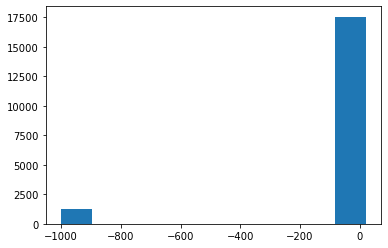

In [23]:
X_test_hierarchical_gr = X_test_hierarchical.join(df_feat[['Mean_1','Mean_2']],how='left')

X_test_hierarchical_gr = X_test_hierarchical_gr[(X_test_hierarchical_gr['Mean_1']>-900) & (X_test_hierarchical_gr['Mean_2']>-900)]
y_test_original_gr = y_test_original[X_test_hierarchical_gr.index]


X_test_hierarchical_gr = X_test_hierarchical_gr.drop(['Mean_1','Mean_2'],axis=1)
r_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_2") or (f=='g-r_max') or (f=='g-r_mean') or (f=='r-W2') or (f=='r-W3')]
g_feat = [f for f in X_test_hierarchical_gr.columns if (f[-2:]=="_1") or (f=='g-r_max') or (f=='g-r_mean') or (f=='g-W2') or (f=='g-W3')]


X_test_hierarchical_g = X_test_hierarchical_gr.copy()
print(X_test_hierarchical_g)
X_test_hierarchical_g[r_feat] = -999
print(X_test_hierarchical_g)

X_test_hierarchical_r = X_test_hierarchical_gr.copy()
X_test_hierarchical_r[g_feat] = -999

plt.hist(X_test_hierarchical_g['g-W2'].values)

In [24]:
Accuracy_first_layer = np.array(list_Accuracy_first_layer)
print("macro Acc first layer",np.mean(Accuracy_first_layer), np.std(Accuracy_first_layer))

Balanced_Accuracy_first_layer = np.array(list_Balanced_Accuracy_first_layer)
print("Balanced Acc first layer", np.mean(Balanced_Accuracy_first_layer), np.std(Balanced_Accuracy_first_layer))

precision_first_layer = np.array(list_precision_first_layer)
print("Precision", np.mean(precision_first_layer), np.std(precision_first_layer))

recall_first_layer = np.array(list_recall_first_layer)
print("Recall ",np.mean(recall_first_layer), np.std(recall_first_layer))

F1_first_layer = np.array(list_F1_Accuracy_first_layer)
print("F1 ", np.mean(F1_first_layer), np.std(F1_first_layer))


Accuracy_last_layer = np.array(list_Accuracy_last_layer)
print("Accuracy ",np.mean(Accuracy_last_layer), np.std(Accuracy_last_layer))

Balanced_Accuracy_last_layer = np.array(list_Balanced_Accuracy_last_layer)
print("Balanced Accuracy ",np.mean(Balanced_Accuracy_last_layer), np.std(Balanced_Accuracy_last_layer))

precision_last_layer = np.array(list_precision_last_layer)
print("Precision", np.mean(precision_last_layer), np.std(precision_last_layer))

recall_last_layer = np.array(list_recall_last_layer)
print("Recall ",np.mean(recall_last_layer), np.std(recall_last_layer))

F1_last_layer = np.array(list_F1_Accuracy_last_layer)
print("F1 ", np.mean(F1_last_layer), np.std(F1_last_layer))


array_cnf_matrix = np.array(list_cnf_matrix)

array_cnf_matrix_hier = np.array(list_cnf_matrix_hier) 
#print(array_cnf_matrix_hier)

#print(np.mean(array_cnf_matrix_hier,axis=0))
#print(np.std(array_cnf_matrix_hier,axis=0))

macro Acc first layer 0.9875263157894736 0.0005248968727667199
Balanced Acc first layer 0.9866983788446817 0.0009330836276302667
Precision 0.9573671149385488 0.004068398659257718
Recall  0.9866983788446817 0.0009330836276302667
F1  0.9709978899942427 0.0025964731709362254
Accuracy  0.8312206477732795 0.0029349930106997513
Balanced Accuracy  0.756864154973816 0.016677229422823243
Precision 0.5667148244568432 0.008812316463794042
Recall  0.756864154973816 0.016677229422823243
F1  0.593314174081228 0.011169698832816334


Normalized confusion matrix


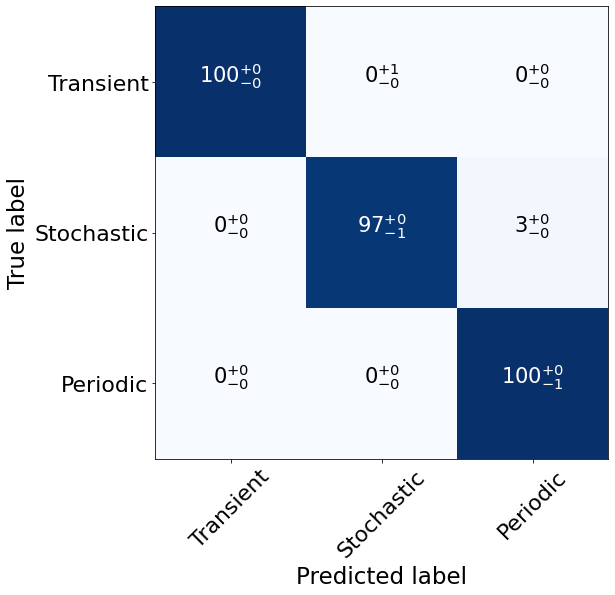

In [25]:
#hierarchical conf matrix

plot_confusion_matrix(np.median(array_cnf_matrix_hier,axis=0), np.percentile(array_cnf_matrix_hier,5,axis=0),np.percentile(array_cnf_matrix_hier,95,axis=0),cm_classes_hierachical,'../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_hierarchical_original_hierarchical_classes.pdf',font=21,fig_x = 10, fig_y = 8)
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_hierarchical.pdf')


Normalized confusion matrix


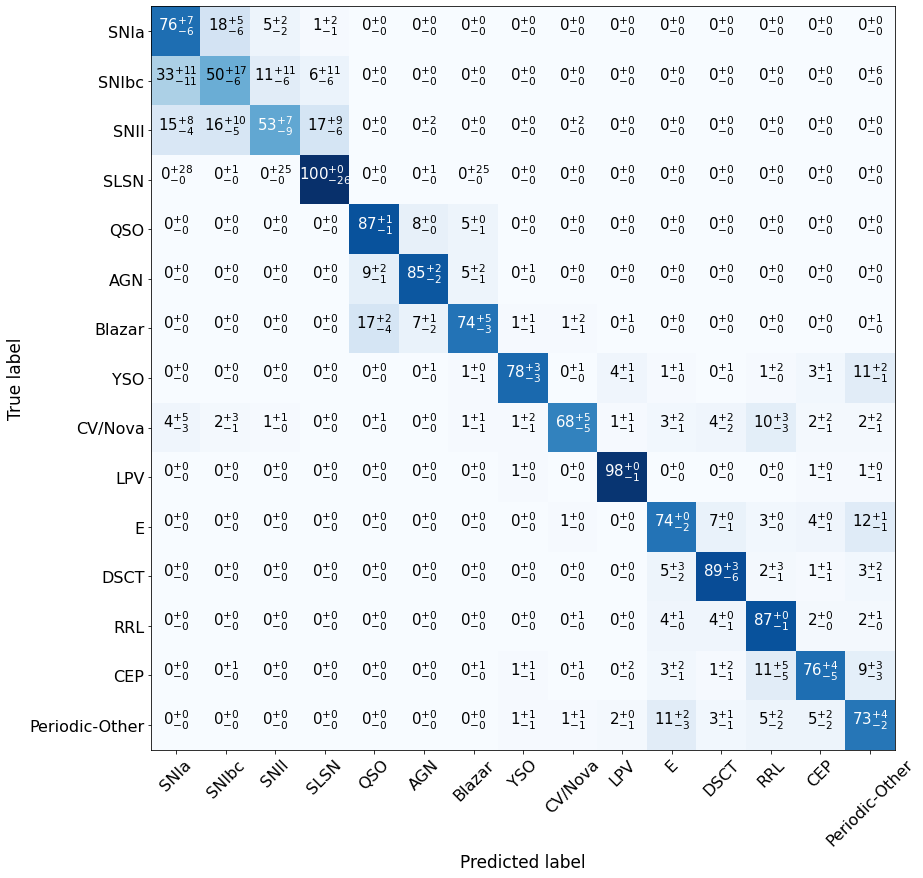

In [26]:
#multiclass conf matrix
#print(np.percentile(array_cnf_matrix,95,axis=0))
#print(np.percentile(array_cnf_matrix,50,axis=0))

plot_confusion_matrix(np.median(array_cnf_matrix,axis=0), np.percentile(array_cnf_matrix,5,axis=0),np.percentile(array_cnf_matrix,95,axis=0),label_order, '../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_multiclass_original_hierarchical_classes.pdf',font=15,fig_x = 20, fig_y = 12)
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_multiclass.pdf')


In [27]:
#function to create plots for each class

def plot_accuracy_1class(bins, gr_array, g_array, r_array, gr_nsamp, g_nsamp, r_nsamp,label,ax = None, xlabel = True, ylabel = True, xlabel_name ='average magnitude',xlimit=(13, 21),lowper=5,highper=95,nsam_perbin=10):
    ax = ax or plt.gca()
    
    
    mask = (gr_nsamp<nsam_perbin)
    gr_array[mask] = np.nan
    
    gr_median = np.nanmedian(gr_array,axis=0)
    gr_low = np.nanpercentile(gr_array,lowper,axis=0)
    gr_high = np.nanpercentile(gr_array,highper,axis=0)
    
    gr_n = np.where(gr_median>-1)
    
    gr_median = gr_median[gr_n[0]]
    gr_low = gr_low[gr_n[0]]
    gr_high = gr_high[gr_n[0]]
    gr_bins = bins[gr_n[0]]
    
    ax.plot(gr_bins,gr_median,'ko-',label=r'g+r')
    ax.fill_between(gr_bins, gr_low, gr_high,alpha=0.2,  facecolor='black')

    mask = (g_nsamp<nsam_perbin)
    g_array[mask] = np.nan
    
    g_median = np.nanmedian(g_array,axis=0)
    g_low = np.nanpercentile(g_array,lowper,axis=0)
    g_high = np.nanpercentile(g_array,highper,axis=0)
    
    g_n = np.where(g_median>-1)
    g_median = g_median[g_n[0]]
    g_low = g_low[g_n[0]]
    g_high = g_high[g_n[0]]
    g_bins = bins[g_n[0]]
    
    
    ax.plot(g_bins,g_median,'b>-',label=r'g')
    ax.fill_between(g_bins, g_low, g_high,alpha=0.2,  facecolor='blue')
    
    mask = (r_nsamp<nsam_perbin)
    r_array[mask] = np.nan
    
    r_median = np.nanmedian(r_array,axis=0)
    r_low = np.nanpercentile(r_array,lowper,axis=0)
    r_high = np.nanpercentile(r_array,highper,axis=0)
    
    r_n = np.where(r_median>-1)
    
    r_median = r_median[r_n[0]]
    r_low = r_low[r_n[0]]
    r_high = r_high[r_n[0]]
    r_bins = bins[r_n[0]]
    
    ax.plot(r_bins,r_median,'rs-',label=r'r')
    ax.fill_between(r_bins, r_low, r_high,alpha=0.2,  facecolor='red')
    
    ax.set_title(label)
    ax.set_ylim(0,1.1)
    ax.set_xlim(xlimit)
    plt.legend(loc= 'lower right',fontsize=14)
    if xlabel: ax.set_xlabel(xlabel_name,fontsize=12)
    if ylabel: ax.set_ylabel('Recall',fontsize=12)
    
    

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

(20, 18)
(18,)


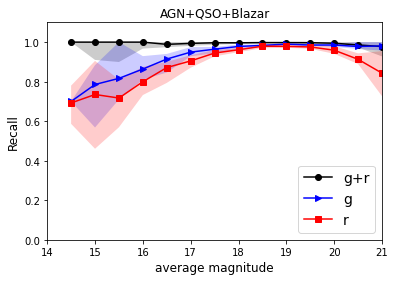

In [28]:
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_AQB, array_acc_mag_gband_AQB, array_acc_mag_rband_AQB, array_nsamp_mag_grband_AQB, array_nsamp_mag_gband_AQB, array_nsamp_mag_rband_AQB,'AGN+QSO+Blazar',xlimit=(14,21))
plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/recall_agn_qso_blazar_for_mag.pdf',bbox_inches='tight')
print((array_acc_mag_grband_AQB).shape)
print(bins_mag_r.shape)

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

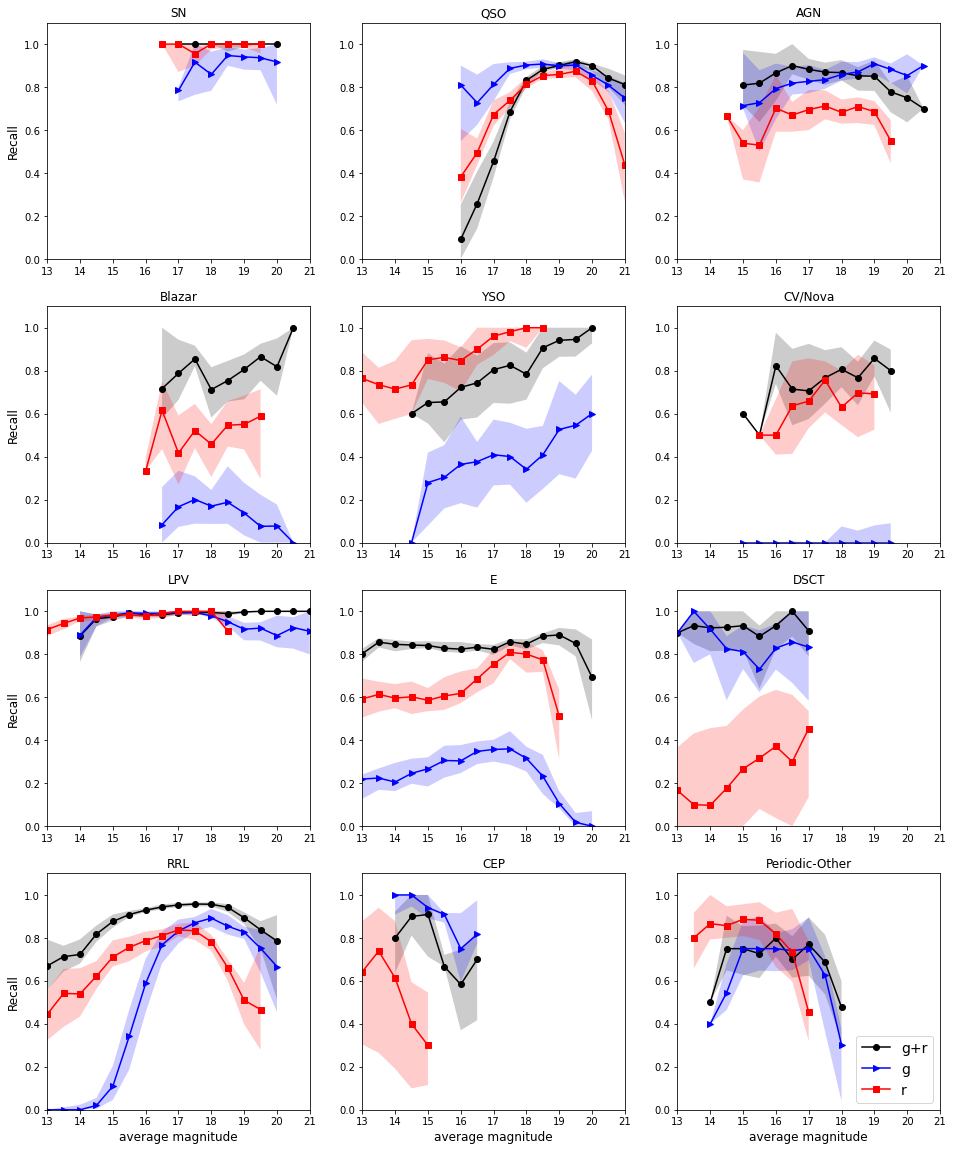

In [29]:
fig, axarr = plt.subplots(4, 3, figsize=(16,20))

plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_transients, array_acc_mag_gband_transients, array_acc_mag_rband_transients, array_nsamp_mag_grband_transients, array_nsamp_mag_gband_transients, array_nsamp_mag_rband_transients,'SN',ax=axarr[0,0],xlabel=False )



plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_QSO, array_acc_mag_gband_QSO, array_acc_mag_rband_QSO, array_nsamp_mag_grband_QSO, array_nsamp_mag_gband_QSO, array_nsamp_mag_rband_QSO,'QSO', ax=axarr[0,1],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_AGN, array_acc_mag_gband_AGN, array_acc_mag_rband_AGN, array_nsamp_mag_grband_AGN, array_nsamp_mag_gband_AGN, array_nsamp_mag_rband_AGN,'AGN', ax=axarr[0,2],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Blazar, array_acc_mag_gband_Blazar, array_acc_mag_rband_Blazar, array_nsamp_mag_grband_Blazar, array_nsamp_mag_gband_Blazar, array_nsamp_mag_rband_Blazar,'Blazar', ax=axarr[1,0],xlabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_YSO, array_acc_mag_gband_YSO, array_acc_mag_rband_YSO, array_nsamp_mag_grband_YSO, array_nsamp_mag_gband_YSO, array_nsamp_mag_rband_YSO,'YSO', ax=axarr[1,1],ylabel=False,xlabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_CV, array_acc_mag_gband_CV, array_acc_mag_rband_CV, array_nsamp_mag_grband_CV, array_nsamp_mag_gband_CV, array_nsamp_mag_rband_CV,'CV/Nova',  ax=axarr[1,2],ylabel=False,xlabel=False)
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_LPV, array_acc_mag_gband_LPV, array_acc_mag_rband_LPV, array_nsamp_mag_grband_LPV, array_nsamp_mag_gband_LPV, array_nsamp_mag_rband_LPV,'LPV',  ax=axarr[2,0],xlabel=False)





plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_EB, array_acc_mag_gband_EB, array_acc_mag_rband_EB, array_nsamp_mag_grband_EB, array_nsamp_mag_gband_EB, array_nsamp_mag_rband_EB,'E', ax=axarr[2,1],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_DSCT, array_acc_mag_gband_DSCT, array_acc_mag_rband_DSCT, array_nsamp_mag_grband_DSCT, array_nsamp_mag_gband_DSCT, array_nsamp_mag_rband_DSCT,'DSCT', ax=axarr[2,2],xlabel=False, ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_RRL, array_acc_mag_gband_RRL, array_acc_mag_rband_RRL, array_nsamp_mag_grband_RRL, array_nsamp_mag_gband_RRL, array_nsamp_mag_rband_RRL,'RRL', ax=axarr[3,0] )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Ceph, array_acc_mag_gband_Ceph, array_acc_mag_rband_Ceph, array_nsamp_mag_grband_Ceph, array_nsamp_mag_gband_Ceph, array_nsamp_mag_rband_Ceph,'CEP', ax=axarr[3,1],ylabel=False )
plot_accuracy_1class(bins_mag_r, array_acc_mag_grband_Other, array_acc_mag_gband_Other, array_acc_mag_rband_Other, array_nsamp_mag_grband_Other, array_nsamp_mag_gband_Other, array_nsamp_mag_rband_Other,'Periodic-Other', ax=axarr[3,2],ylabel=False)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/recall_all_for_mag.pdf',bbox_inches='tight')



In [30]:
def plot_accuracy_1class_nsamps(bins_gr, bins_g, bins_r, gr_array, g_array, r_array, gr_nsamp, g_nsamp, r_nsamp,label,ax = None, xlabel = True, ylabel = True, xlabel_name =r'$\# \mathrm{detections}$',xlimit=(5,150),lowper=5,highper=95,nsam_perbin=10):
    
    ax = ax or plt.gca()
    #print(bins)
    #print(gr_array)
    
    mask = (gr_nsamp<nsam_perbin)
    gr_array[mask] = np.nan
    
    gr_median = np.nanmedian(gr_array,axis=0)
    gr_low = np.nanpercentile(gr_array,lowper,axis=0)
    gr_high = np.nanpercentile(gr_array,highper,axis=0)
    
    gr_n = np.where(gr_median>-1)
    
    gr_median = gr_median[gr_n[0]]
    gr_low = gr_low[gr_n[0]]
    gr_high = gr_high[gr_n[0]]
    gr_bins = bins_gr[gr_n[0]]
    
    ax.plot(gr_bins,gr_median,'ko-',label=r'g+r')
    ax.fill_between(gr_bins, gr_low, gr_high,alpha=0.2,  facecolor='black')

    mask = (g_nsamp<nsam_perbin)
    g_array[mask] = np.nan
    
    g_median = np.nanmedian(g_array,axis=0)
    g_low = np.nanpercentile(g_array,lowper,axis=0)
    g_high = np.nanpercentile(g_array,highper,axis=0)
    
    g_n = np.where(g_median>-1)
    g_median = g_median[g_n[0]]
    g_low = g_low[g_n[0]]
    g_high = g_high[g_n[0]]
    g_bins = bins_g[g_n[0]]
    
    
    ax.plot(g_bins,g_median,'b>-',label=r'g')
    ax.fill_between(g_bins, g_low, g_high,alpha=0.2,  facecolor='blue')
    
    mask = (r_nsamp<nsam_perbin)
    r_array[mask] = np.nan
    
    r_median = np.nanmedian(r_array,axis=0)
    r_low = np.nanpercentile(r_array,lowper,axis=0)
    r_high = np.nanpercentile(r_array,highper,axis=0)
    
    r_n = np.where(r_median>-1)
    
    r_median = r_median[r_n[0]]
    r_low = r_low[r_n[0]]
    r_high = r_high[r_n[0]]
    r_bins = bins_r[r_n[0]]
    
    ax.plot(r_bins,r_median,'rs-',label=r'r')
    ax.fill_between(r_bins, r_low, r_high,alpha=0.2,  facecolor='red')
    
    ax.set_title(label)
    ax.set_ylim(0,1.1)
    ax.set_xlim(xlimit)
    ax.set_xscale('log')
    plt.legend(loc='lower right', fontsize=14)
    if xlabel: ax.set_xlabel(xlabel_name,fontsize=12)
    if ylabel: ax.set_ylabel('Recall',fontsize=12)
    
    

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

No handles with labels found to put in legend.
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/pyt

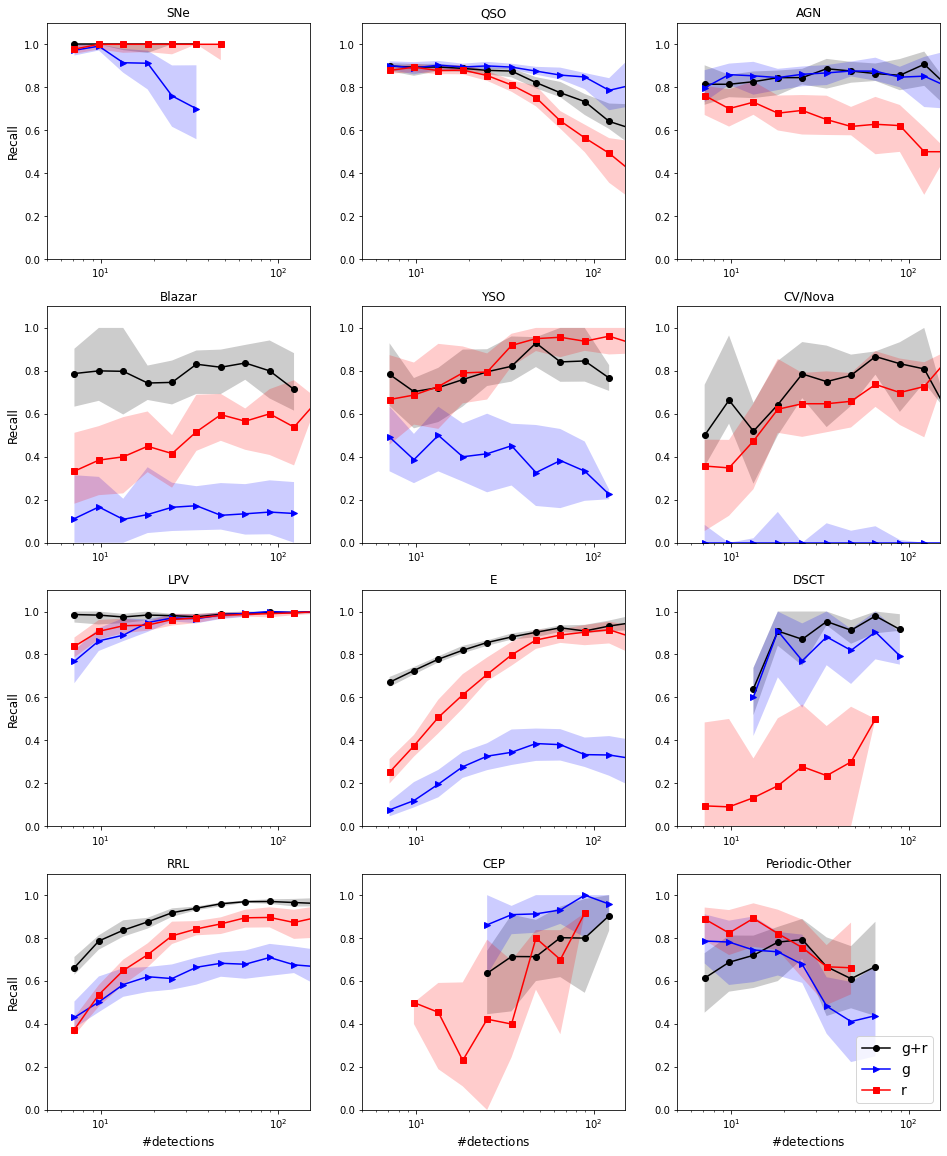

In [31]:
fig2, axarr2 = plt.subplots(4, 3, figsize=(16,20))
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_transients, array_acc_nsamp_gband_transients, array_acc_nsamp_rband_transients, array_nsamp_nsamp_grband_transients, array_nsamp_nsamp_gband_transients, array_nsamp_nsamp_rband_transients,'SNe',ax=axarr2[0,0],xlabel=False )


plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_QSO, array_acc_nsamp_gband_QSO, array_acc_nsamp_rband_QSO, array_nsamp_nsamp_grband_QSO, array_nsamp_nsamp_gband_QSO, array_nsamp_nsamp_rband_QSO,'QSO', ax=axarr2[0,1],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_AGN, array_acc_nsamp_gband_AGN, array_acc_nsamp_rband_AGN, array_nsamp_nsamp_grband_AGN, array_nsamp_nsamp_gband_AGN, array_nsamp_nsamp_rband_AGN,'AGN', ax=axarr2[0,2],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Blazar, array_acc_nsamp_gband_Blazar, array_acc_nsamp_rband_Blazar, array_nsamp_nsamp_grband_Blazar, array_nsamp_nsamp_gband_Blazar, array_nsamp_nsamp_rband_Blazar,'Blazar', ax=axarr2[1,0],xlabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_YSO, array_acc_nsamp_gband_YSO, array_acc_nsamp_rband_YSO, array_nsamp_nsamp_grband_YSO, array_nsamp_nsamp_gband_YSO, array_nsamp_nsamp_rband_YSO,'YSO', ax=axarr2[1,1],ylabel=False,xlabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_CV, array_acc_nsamp_gband_CV, array_acc_nsamp_rband_CV, array_nsamp_nsamp_grband_CV, array_nsamp_nsamp_gband_CV, array_nsamp_nsamp_rband_CV,'CV/Nova', ax=axarr2[1,2],ylabel=False,xlabel=False)
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_LPV, array_acc_nsamp_gband_LPV, array_acc_nsamp_rband_LPV, array_nsamp_nsamp_grband_LPV, array_nsamp_nsamp_gband_LPV, array_nsamp_nsamp_rband_LPV,'LPV', ax=axarr2[2,0],xlabel=False )



plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_EB, array_acc_nsamp_gband_EB, array_acc_nsamp_rband_EB, array_nsamp_nsamp_grband_EB, array_nsamp_nsamp_gband_EB, array_nsamp_nsamp_rband_EB,'E', ax=axarr2[2,1],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_DSCT, array_acc_nsamp_gband_DSCT, array_acc_nsamp_rband_DSCT, array_nsamp_nsamp_grband_DSCT, array_nsamp_nsamp_gband_DSCT, array_nsamp_nsamp_rband_DSCT,'DSCT', ax=axarr2[2,2],xlabel=False, ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_RRL, array_acc_nsamp_gband_RRL, array_acc_nsamp_rband_RRL, array_nsamp_nsamp_grband_RRL, array_nsamp_nsamp_gband_RRL, array_nsamp_nsamp_rband_RRL,'RRL', ax=axarr2[3,0] )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Ceph, array_acc_nsamp_gband_Ceph, array_acc_nsamp_rband_Ceph, array_nsamp_nsamp_grband_Ceph, array_nsamp_nsamp_gband_Ceph, array_nsamp_nsamp_rband_Ceph,'CEP', ax=axarr2[3,1],ylabel=False )
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_Other, array_acc_nsamp_gband_Other, array_acc_nsamp_rband_Other, array_nsamp_nsamp_grband_Other, array_nsamp_nsamp_gband_Other, array_nsamp_nsamp_rband_Other,'Periodic-Other', ax=axarr2[3,2],ylabel=False)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/recall_all_for_ndet.pdf',bbox_inches='tight')

/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: 

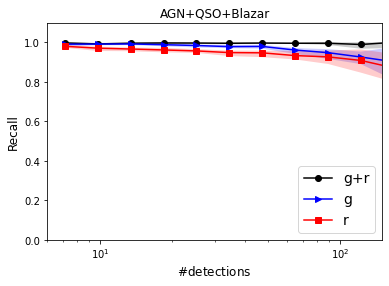

In [32]:
plot_accuracy_1class_nsamps(bins_nsamp_gr,bins_nsamp_g,bins_nsamp_r, array_acc_nsamp_grband_AQB, array_acc_nsamp_gband_AQB, array_acc_nsamp_rband_AQB, array_nsamp_nsamp_grband_AQB, array_nsamp_nsamp_gband_AQB, array_nsamp_nsamp_rband_AQB,'AGN+QSO+Blazar',xlimit=(6,150))

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/recall_agn_qso_blazar_for_ndet.pdf',bbox_inches='tight')

In [33]:
df_for_figures = df.copy()
df_for_figures = df_for_figures.join(labels)
df_for_figures.head()

,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2,class_original,class_hierachical
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aapcxhy,0.068704,0.052665,0.665183,0.501831,1.0,1.0,0.250000,0.307692,0.0,0.0,...,0.796,2.889,8.106832,5.217832,8.668390,5.779390,0.202128,1.155121,AGN,Stochastic
ZTF18abtmwvo,0.115177,-999.000000,0.996398,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.807,2.964,-999.000000,-999.000000,9.126021,6.162021,0.081005,-999.000000,AGN,Stochastic
ZTF18acvgdfy,0.050608,-999.000000,0.353987,-999.000000,1.0,-999.0,0.500000,-999.000000,0.0,-999.0,...,0.606,2.876,-999.000000,-999.000000,8.483215,5.607215,0.023222,-999.000000,AGN,Stochastic
ZTF19aabvjsi,-999.000000,0.028547,-999.000000,0.494246,-999.0,1.0,-999.000000,0.333333,-999.0,0.0,...,0.938,3.017,8.099364,5.082364,-999.000000,-999.000000,-999.000000,0.529107,AGN,Stochastic
ZTF18aadyxlg,-999.000000,0.021935,-999.000000,0.543918,-999.0,1.0,-999.000000,0.500000,-999.0,0.0,...,0.959,3.021,8.041334,5.020334,-999.000000,-999.000000,-999.000000,0.277404,AGN,Stochastic


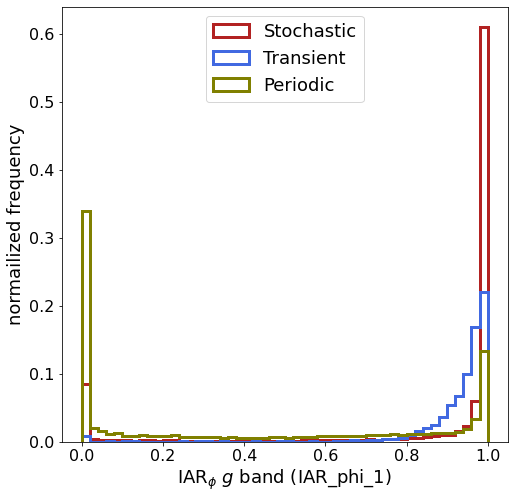

In [34]:
bins_hist = np.arange(0,1.01,0.02)

fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Stochastic'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Stochastic'].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Stochastic'].values,weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic', alpha=1.0)

weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Transient'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Transient'].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Transient'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='Transient', alpha=1.0)

weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Periodic'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Periodic'].values))  
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Periodic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic', alpha=1.0)

    
plt.legend(loc='upper center',fontsize=18)
plt.xlabel(r'IAR$_{\phi}$ $g$ band (IAR_phi_1)',fontsize=18)
plt.ylabel(r'normailized frequency',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/IAR_phi_1_hierarchical.pdf',bbox_inches='tight')

[5.00000000e-08 1.34332033e-07 3.60901902e-07 9.69613724e-07
 2.60500365e-06 6.99870874e-06 1.88030155e-05 5.05169459e-05
 1.35720881e-04 3.64633237e-04 9.79638480e-04 2.63193657e-03
 7.07106781e-03 1.89974183e-02 5.10392364e-02 1.37124088e-01
 3.68403150e-01 9.89766882e-01 2.65914795e+00 7.14417500e+00
 1.91938310e+01 5.15669269e+01 1.38541802e+02 3.72212040e+02
 1.00000000e+03]


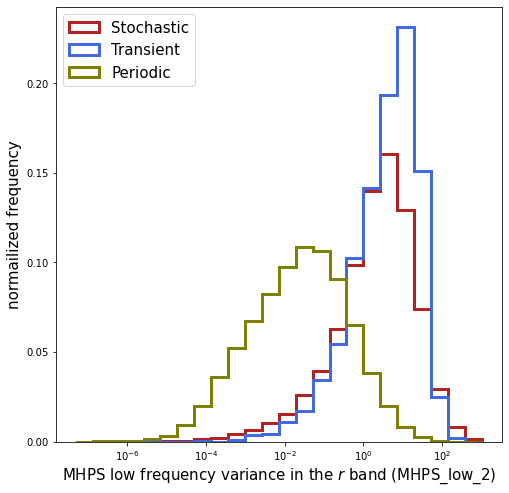

In [35]:
#bins_hist = np.arange(0,1.01,0.02)
bins_hist = np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['MHPS_low_2'][df_for_figures['class_hierachical']=='Stochastic'].values)/float(len(df_for_figures['MHPS_low_2'][df_for_figures['class_hierachical']=='Stochastic'].values))
plt.hist(df_for_figures['MHPS_low_2'][df_for_figures['class_hierachical']=='Stochastic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic', alpha=1.0)
weights = np.ones_like(df_for_figures['MHPS_low_2'][df_for_figures['class_hierachical']=='Transient'].values)/float(len(df_for_figures['MHPS_low_2'][df_for_figures['class_hierachical']=='Transient'].values))
plt.hist(df_for_figures['MHPS_low_2'][df_for_figures['class_hierachical']=='Transient'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='Transient', alpha=1.0)
weights = np.ones_like(df_for_figures['MHPS_low_2'][df_for_figures['class_hierachical']=='Periodic'].values)/float(len(df_for_figures['MHPS_low_2'][df_for_figures['class_hierachical']=='Periodic'].values))
plt.hist(df_for_figures['MHPS_low_2'][df_for_figures['class_hierachical']=='Periodic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic', alpha=1.0)
plt.legend(loc='upper left',fontsize=15)
plt.xlabel(r'MHPS low frequency variance in the $r$ band (MHPS_low_2)',fontsize=15)
plt.ylabel(r'normailized frequency',fontsize=15)
plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/aps_low_2_hierarchical.pdf',bbox_inches='tight')

[5.00000000e-08 1.34332033e-07 3.60901902e-07 9.69613724e-07
 2.60500365e-06 6.99870874e-06 1.88030155e-05 5.05169459e-05
 1.35720881e-04 3.64633237e-04 9.79638480e-04 2.63193657e-03
 7.07106781e-03 1.89974183e-02 5.10392364e-02 1.37124088e-01
 3.68403150e-01 9.89766882e-01 2.65914795e+00 7.14417500e+00
 1.91938310e+01 5.15669269e+01 1.38541802e+02 3.72212040e+02
 1.00000000e+03]


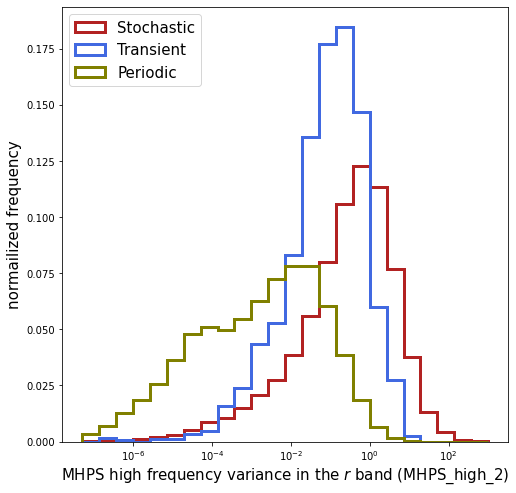

In [36]:
#bins_hist = np.arange(0,1.01,0.02)
bins_hist = np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['MHPS_high_2'][df_for_figures['class_hierachical']=='Stochastic'].values)/float(len(df_for_figures['MHPS_high_2'][df_for_figures['class_hierachical']=='Stochastic'].values))
plt.hist(df_for_figures['MHPS_high_2'][df_for_figures['class_hierachical']=='Stochastic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic', alpha=1.0)
weights = np.ones_like(df_for_figures['MHPS_high_2'][df_for_figures['class_hierachical']=='Transient'].values)/float(len(df_for_figures['MHPS_high_2'][df_for_figures['class_hierachical']=='Transient'].values))
plt.hist(df_for_figures['MHPS_high_2'][df_for_figures['class_hierachical']=='Transient'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='Transient', alpha=1.0)
weights = np.ones_like(df_for_figures['MHPS_high_2'][df_for_figures['class_hierachical']=='Periodic'].values)/float(len(df_for_figures['MHPS_high_2'][df_for_figures['class_hierachical']=='Periodic'].values))
plt.hist(df_for_figures['MHPS_high_2'][df_for_figures['class_hierachical']=='Periodic'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic', alpha=1.0)
plt.legend(loc='upper left',fontsize=15)
plt.xlabel(r'MHPS high frequency variance in the $r$ band (MHPS_high_2)',fontsize=15)
plt.ylabel(r'normailized frequency',fontsize=15)
plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/aps_high_2_hierarchical.pdf',bbox_inches='tight')

[5.00000000e-08 1.34332033e-07 3.60901902e-07 9.69613724e-07
 2.60500365e-06 6.99870874e-06 1.88030155e-05 5.05169459e-05
 1.35720881e-04 3.64633237e-04 9.79638480e-04 2.63193657e-03
 7.07106781e-03 1.89974183e-02 5.10392364e-02 1.37124088e-01
 3.68403150e-01 9.89766882e-01 2.65914795e+00 7.14417500e+00
 1.91938310e+01 5.15669269e+01 1.38541802e+02 3.72212040e+02
 1.00000000e+03]


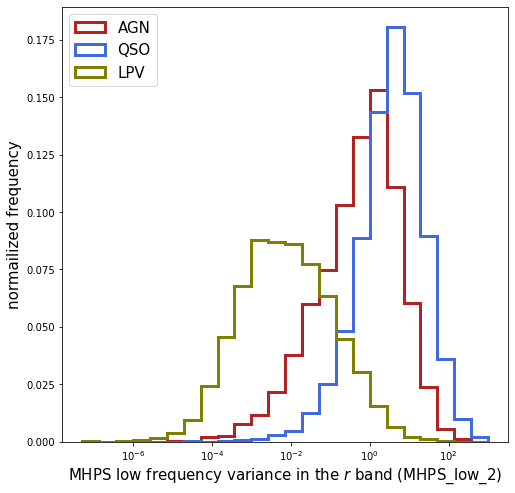

In [37]:
#bins_hist = np.arange(0,1.01,0.02)
bins_hist = np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['MHPS_low_2'][df_for_figures['class_original']=='AGN'].values)/float(len(df_for_figures['MHPS_low_2'][df_for_figures['class_original']=='AGN'].values))
plt.hist(df_for_figures['MHPS_low_2'][df_for_figures['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures['MHPS_low_2'][df_for_figures['class_original']=='QSO'].values)/float(len(df_for_figures['MHPS_low_2'][df_for_figures['class_original']=='QSO'].values))
plt.hist(df_for_figures['MHPS_low_2'][df_for_figures['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures['MHPS_low_2'][df_for_figures['class_original']=='LPV'].values)/float(len(df_for_figures['MHPS_low_2'][df_for_figures['class_original']=='LPV'].values))
plt.hist(df_for_figures['MHPS_low_2'][df_for_figures['class_original']=='LPV'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='LPV', alpha=1.0)
plt.legend(loc='upper left',fontsize=15)
plt.xlabel(r'MHPS low frequency variance in the $r$ band (MHPS_low_2)',fontsize=15)
plt.ylabel(r'normailized frequency',fontsize=15)
plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/aps_low_2_stochastics.pdf',bbox_inches='tight')

[5.00000000e-08 1.34332033e-07 3.60901902e-07 9.69613724e-07
 2.60500365e-06 6.99870874e-06 1.88030155e-05 5.05169459e-05
 1.35720881e-04 3.64633237e-04 9.79638480e-04 2.63193657e-03
 7.07106781e-03 1.89974183e-02 5.10392364e-02 1.37124088e-01
 3.68403150e-01 9.89766882e-01 2.65914795e+00 7.14417500e+00
 1.91938310e+01 5.15669269e+01 1.38541802e+02 3.72212040e+02
 1.00000000e+03]


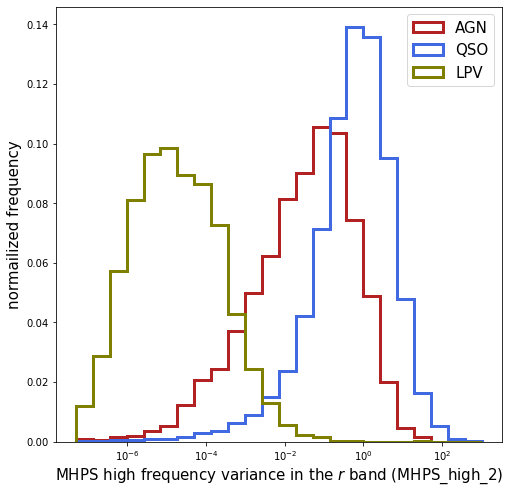

In [38]:
#bins_hist = np.arange(0,1.01,0.02)
bins_hist = np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['MHPS_high_2'][df_for_figures['class_original']=='AGN'].values)/float(len(df_for_figures['MHPS_high_2'][df_for_figures['class_original']=='AGN'].values))
plt.hist(df_for_figures['MHPS_high_2'][df_for_figures['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures['MHPS_high_2'][df_for_figures['class_original']=='QSO'].values)/float(len(df_for_figures['MHPS_high_2'][df_for_figures['class_original']=='QSO'].values))
plt.hist(df_for_figures['MHPS_high_2'][df_for_figures['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures['MHPS_high_2'][df_for_figures['class_original']=='LPV'].values)/float(len(df_for_figures['MHPS_high_2'][df_for_figures['class_original']=='LPV'].values))
plt.hist(df_for_figures['MHPS_high_2'][df_for_figures['class_original']=='LPV'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='LPV', alpha=1.0)
plt.legend(loc='upper right',fontsize=15)
plt.xlabel(r'MHPS high frequency variance in the $r$ band (MHPS_high_2)',fontsize=15)
plt.ylabel(r'normailized frequency',fontsize=15)
plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/paps_high_2_stochastics.pdf',bbox_inches='tight')

[ 2.          2.27586207  2.55172414  2.82758621  3.10344828  3.37931034
  3.65517241  3.93103448  4.20689655  4.48275862  4.75862069  5.03448276
  5.31034483  5.5862069   5.86206897  6.13793103  6.4137931   6.68965517
  6.96551724  7.24137931  7.51724138  7.79310345  8.06896552  8.34482759
  8.62068966  8.89655172  9.17241379  9.44827586  9.72413793 10.        ]


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 <a list of 9 Text major ticklabel objects>)

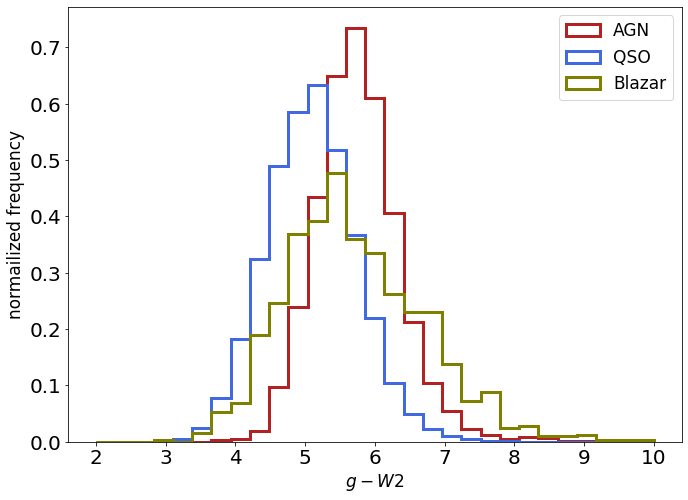

In [39]:
#bins_hist = np.arange(0,1.01,0.02)
feature='g-W2'
bins_hist = np.linspace(2,10,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
print(bins_hist)
fi = plt.figure(figsize=(11,8))
plt.hist(df_for_figures[feature][df_for_figures['class_original']=='AGN'].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
plt.hist(df_for_figures[feature][df_for_figures['class_original']=='QSO'].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
plt.hist(df_for_figures[feature][df_for_figures['class_original']=='Blazar'].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper right',fontsize=17)
plt.xlabel(r'$g-W2$',fontsize=17)
plt.ylabel(r'normailized frequency',fontsize=17)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/g_W2_agn_classes.pdf',bbox_inches='tight')

[5.00000000e-03 6.66760716e-03 8.89139705e-03 1.18568685e-02
 1.58113883e-02 2.10848252e-02 2.81170663e-02 3.74947105e-02
 5.00000000e-02 6.66760716e-02 8.89139705e-02 1.18568685e-01
 1.58113883e-01 2.10848252e-01 2.81170663e-01 3.74947105e-01
 5.00000000e-01 6.66760716e-01 8.89139705e-01 1.18568685e+00
 1.58113883e+00 2.10848252e+00 2.81170663e+00 3.74947105e+00
 5.00000000e+00]


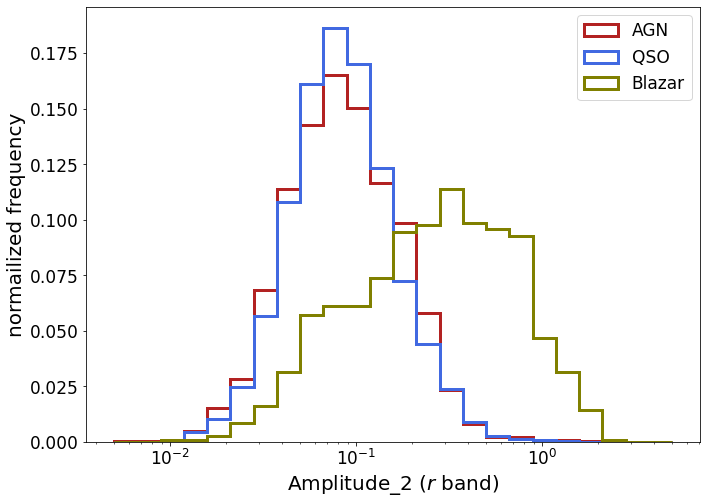

In [40]:
#bins_hist = np.arange(0,1.01,0.02)
feature='Amplitude_2'
bins_hist = np.logspace(np.log10(5e-3),np.log10(5),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
fi = plt.figure(figsize=(11,8))
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper right',fontsize=17)
plt.xlabel(r'Amplitude_2 ($r$ band)',fontsize=20)
plt.ylabel(r'normailized frequency',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/amplitude_rband_agn_classes.pdf',bbox_inches='tight')

[2.00000000e-04 3.04984309e-04 4.65077144e-04 7.09206156e-04
 1.08148375e-03 1.64917787e-03 2.51486686e-03 3.83497466e-03
 5.84803548e-03 8.91779529e-03 1.35989382e-02 2.07373138e-02
 3.16227766e-02 4.82222533e-02 7.35351531e-02 1.12135339e-01
 1.70997595e-01 2.60757916e-01 3.97635364e-01 6.06362734e-01
 9.24655597e-01 1.41002724e+00 2.15018092e+00 3.27885721e+00
 5.00000000e+00]


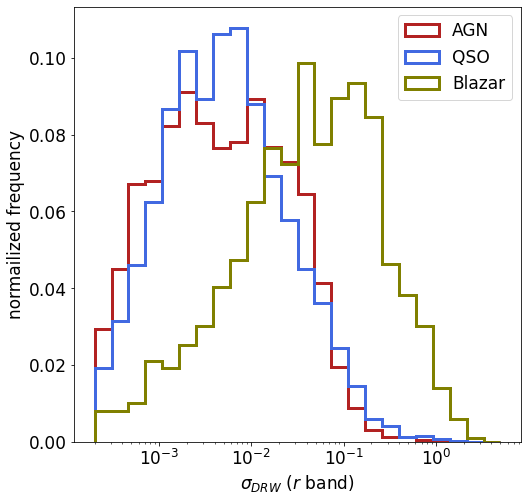

In [41]:
#bins_hist = np.arange(0,1.01,0.02)
feature='GP_DRW_sigma_2'
bins_hist = np.logspace(np.log10(2e-4),np.log10(5),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper right',fontsize=17)
plt.xlabel(r'$\sigma_{DRW}$ ($r$ band)',fontsize=17)
plt.ylabel(r'normailized frequency',fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/drw_sigma_rband_agn_classes.pdf',bbox_inches='tight')

[2.00000000e-04 3.04984309e-04 4.65077144e-04 7.09206156e-04
 1.08148375e-03 1.64917787e-03 2.51486686e-03 3.83497466e-03
 5.84803548e-03 8.91779529e-03 1.35989382e-02 2.07373138e-02
 3.16227766e-02 4.82222533e-02 7.35351531e-02 1.12135339e-01
 1.70997595e-01 2.60757916e-01 3.97635364e-01 6.06362734e-01
 9.24655597e-01 1.41002724e+00 2.15018092e+00 3.27885721e+00
 5.00000000e+00]


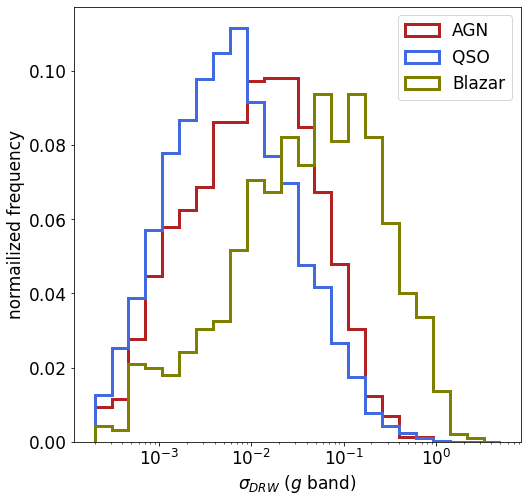

In [42]:
#bins_hist = np.arange(0,1.01,0.02)
feature='GP_DRW_sigma_1'
bins_hist = np.logspace(np.log10(2e-4),np.log10(5),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper right',fontsize=17)
plt.xlabel(r'$\sigma_{DRW}$ ($g$ band)',fontsize=17)
plt.ylabel(r'normailized frequency',fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.xscale('log')

[   5.            6.6059014     8.72758666   11.53071539   15.23415379
   20.12706357   26.59147948   35.13213831   46.41588834   61.32375635
   81.01973759  107.0416796   141.42135624  186.84310704  246.85342849
  326.13788179  430.88693801  569.27932543  752.12061862  993.68692955
 1312.83957589 1734.49775857 2291.58423445 3027.59590068 4000.        ]


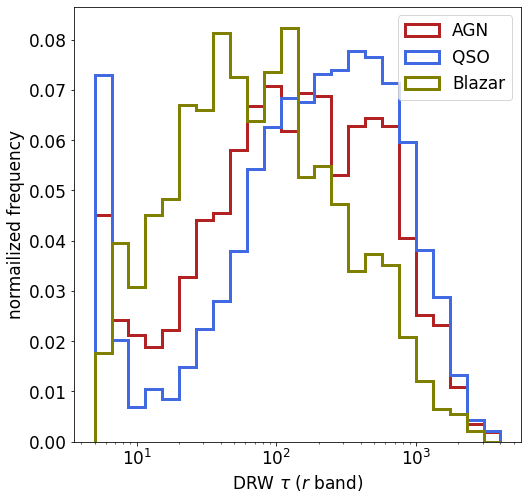

In [43]:
#bins_hist = np.arange(0,1.01,0.02)
feature='GP_DRW_tau_2'
bins_hist = np.logspace(np.log10(5),np.log10(4000),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper right',fontsize=17)
plt.xlabel(r'DRW $\tau$ ($r$ band)',fontsize=17)
plt.ylabel(r'normailized frequency',fontsize=17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/drw_tau_rband_agn_classes.pdf',bbox_inches='tight')

[2.00000000e-04 3.86803933e-04 7.48086414e-04 1.44681384e-03
 2.79816641e-03 5.41170888e-03 1.04663514e-02 2.02421294e-02
 3.91486764e-02 7.57143101e-02 1.46432965e-01 2.83204234e-01
 5.47722558e-01 1.05930620e+00 2.04871902e+00 3.96226288e+00
 7.66309432e+00 1.48205751e+01 2.86632838e+01 5.54353545e+01
 1.07213066e+02 2.07352178e+02 4.01023190e+02 7.75586736e+02
 1.50000000e+03]


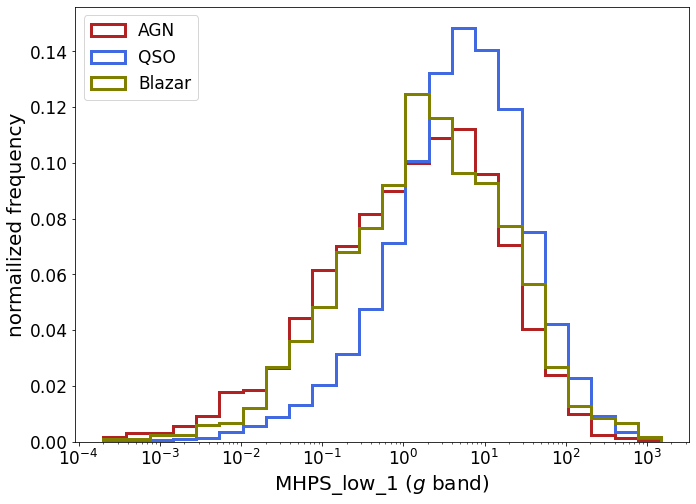

In [44]:
#bins_hist = np.arange(0,1.01,0.02)
feature='MHPS_low_1'
bins_hist = np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
fi = plt.figure(figsize=(11,8))
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper left',fontsize=17)
plt.xlabel(r'MHPS_low_1 ($g$ band)',fontsize=20)
plt.ylabel(r'normailized frequency',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/mhps_low_gband_agn_classes.pdf',bbox_inches='tight')

[0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 <a list of 10 Text major ticklabel objects>)

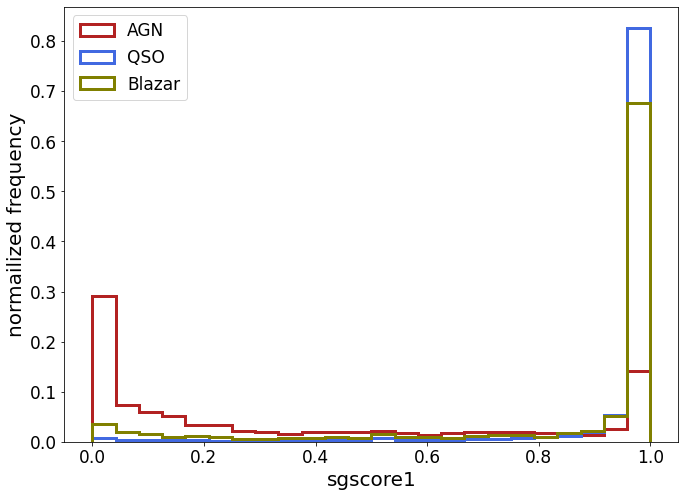

In [45]:
#bins_hist = np.arange(0,1.01,0.02)
feature='sgscore1'
bins_hist = np.linspace(0,1,25,endpoint=True)#np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
fi = plt.figure(figsize=(11,8))
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
plt.hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
plt.legend(loc='upper left',fontsize=17)
plt.xlabel(r'sgscore1',fontsize=20)
plt.ylabel(r'normailized frequency',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
#plt.xscale('log')
#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/sgscore_gband_agn_classes.pdf',bbox_inches='tight')


[-0.4        -0.33793103 -0.27586207 -0.2137931  -0.15172414 -0.08965517
 -0.02758621  0.03448276  0.09655172  0.15862069  0.22068966  0.28275862
  0.34482759  0.40689655  0.46896552  0.53103448  0.59310345  0.65517241
  0.71724138  0.77931034  0.84137931  0.90344828  0.96551724  1.02758621
  1.08965517  1.15172414  1.2137931   1.27586207  1.33793103  1.4       ]
[0.0005     0.00062351 0.00077754 0.00096961 0.00120914 0.00150783
 0.0018803  0.00234479 0.00292402 0.00364633 0.00454708 0.00567034
 0.00707107 0.00881782 0.01099607 0.01371241 0.01709976 0.02132388
 0.02659148 0.03316032 0.04135186 0.05156693 0.06430541 0.08019065
 0.1       ]


Text(0.5, 0, 'sgscore1')

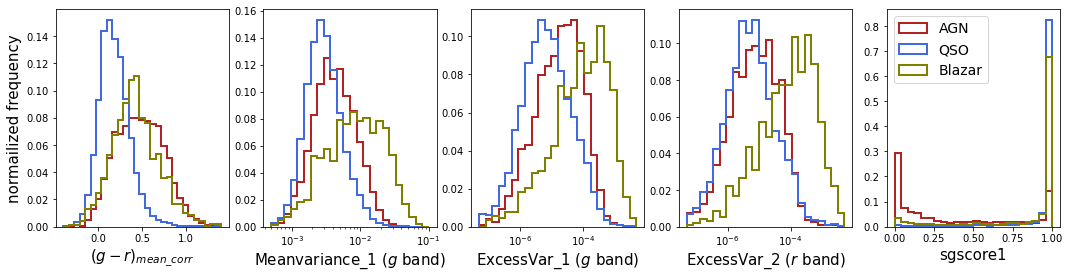

In [46]:
fig, ax = plt.subplots(nrows=1, ncols= 5, figsize = (18,4)) 


feature='g-r_mean_corr'
bins_hist = np.linspace(-0.4,1.4,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[0].legend(loc='upper right',fontsize=17)
ax[0].set_xlabel(r'$(g-r)_{mean\_corr}$',fontsize=15)
ax[0].set_ylabel(r'normailized frequency',fontsize=15)

feature='Meanvariance_1'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[1].legend(loc='upper right',fontsize=17)
ax[1].set_xlabel(r'Meanvariance_1 ($g$ band)',fontsize=15)
#ax[1].set_ylabel(r'normailized frequency',fontsize=15)
ax[1].set_xscale('log')

'''feature='Meanvariance_2'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[1].legend(loc='upper right',fontsize=17)
ax[2].set_xlabel(r'Meanvariance_2 ($r$ band)',fontsize=15)
#ax[1].set_ylabel(r'normailized frequency',fontsize=15)
ax[2].set_xscale('log')'''

feature='ExcessVar_1'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[2].legend(loc='upper left',fontsize=17)
ax[2].set_xlabel(r'ExcessVar_1 ($g$ band)',fontsize=15)
#ax[2].set_ylabel(r'normailized frequency',fontsize=15)
ax[2].set_xscale('log')

feature='ExcessVar_2'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[3].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[3].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[3].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[2].legend(loc='upper left',fontsize=17)
ax[3].set_xlabel(r'ExcessVar_2 ($r$ band)',fontsize=15)
#ax[2].set_ylabel(r'normailized frequency',fontsize=15)
ax[3].set_xscale('log')


feature='sgscore1'
bins_hist = np.linspace(0,1,25,endpoint=True)#np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[4].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[4].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[4].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
ax[4].legend(loc='upper left',fontsize=14)
ax[4].set_xlabel(r'sgscore1',fontsize=15)
#ax[3].set_ylabel(r'normailized frequency',fontsize=15)



#plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/feat_agn_classes.pdf',bbox_inches='tight')



[-0.4        -0.33793103 -0.27586207 -0.2137931  -0.15172414 -0.08965517
 -0.02758621  0.03448276  0.09655172  0.15862069  0.22068966  0.28275862
  0.34482759  0.40689655  0.46896552  0.53103448  0.59310345  0.65517241
  0.71724138  0.77931034  0.84137931  0.90344828  0.96551724  1.02758621
  1.08965517  1.15172414  1.2137931   1.27586207  1.33793103  1.4       ]
[0.0005     0.00062351 0.00077754 0.00096961 0.00120914 0.00150783
 0.0018803  0.00234479 0.00292402 0.00364633 0.00454708 0.00567034
 0.00707107 0.00881782 0.01099607 0.01371241 0.01709976 0.02132388
 0.02659148 0.03316032 0.04135186 0.05156693 0.06430541 0.08019065
 0.1       ]
[0.0005     0.00062351 0.00077754 0.00096961 0.00120914 0.00150783
 0.0018803  0.00234479 0.00292402 0.00364633 0.00454708 0.00567034
 0.00707107 0.00881782 0.01099607 0.01371241 0.01709976 0.02132388
 0.02659148 0.03316032 0.04135186 0.05156693 0.06430541 0.08019065
 0.1       ]


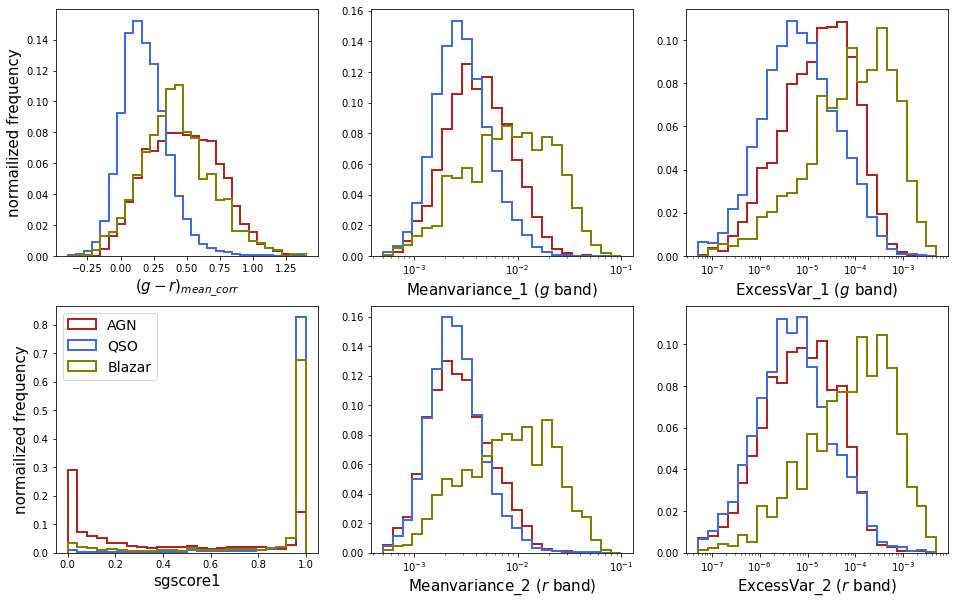

In [47]:
fig, ax = plt.subplots(nrows=2, ncols= 3, figsize = (16,10)) 


feature='g-r_mean_corr'
bins_hist = np.linspace(-0.4,1.4,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[0,0].legend(loc='upper right',fontsize=17)
ax[0,0].set_xlabel(r'$(g-r)_{mean\_corr}$',fontsize=15)
ax[0,0].set_ylabel(r'normailized frequency',fontsize=15)

feature='Meanvariance_1'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[0,1].legend(loc='upper right',fontsize=17)
ax[0,1].set_xlabel(r'Meanvariance_1 ($g$ band)',fontsize=15)
#ax[0,1].set_ylabel(r'normailized frequency',fontsize=15)
ax[0,1].set_xscale('log')

feature='Meanvariance_2'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[1,1].legend(loc='upper right',fontsize=17)
ax[1,1].set_xlabel(r'Meanvariance_2 ($r$ band)',fontsize=15)
#ax[1,1].set_ylabel(r'normailized frequency',fontsize=15)
ax[1,1].set_xscale('log')

feature='ExcessVar_1'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[0,2].legend(loc='upper left',fontsize=17)
ax[0,2].set_xlabel(r'ExcessVar_1 ($g$ band)',fontsize=15)
#ax[0,2].set_ylabel(r'normailized frequency',fontsize=15)
ax[0,2].set_xscale('log')

feature='ExcessVar_2'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[1,2].legend(loc='upper left',fontsize=17)
ax[1,2].set_xlabel(r'ExcessVar_2 ($r$ band)',fontsize=15)
#ax[1,2].set_ylabel(r'normailized frequency',fontsize=15)
ax[1,2].set_xscale('log')


feature='sgscore1'
bins_hist = np.linspace(0,1,25,endpoint=True)#np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
ax[1,0].legend(loc='upper left',fontsize=14)
ax[1,0].set_xlabel(r'sgscore1',fontsize=15)
ax[1,0].set_ylabel(r'normailized frequency',fontsize=15)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/feat_agn_classes.pdf',bbox_inches='tight')




Normalized confusion matrix
[[ 76.  18.   5.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [ 33.  50.  11.   6.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [ 15.  16.  53.  17.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.  87.   8.   5.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   9.  85.   5.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.  17.   7.  74.   1.   1.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   1.  78.   0.   4.   1.   0.   1.   3.
   11.]
 [  4.   2.   1.   0.   0.   0.   1.   1.  68.   1.   3.   4.  10.   2.
    2.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.  98.   0.   0.   0.   1.
    1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  74.   7.   3.   4.
   12.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   5.  89.   2.   1.
    3.]
 [  0.   0. 

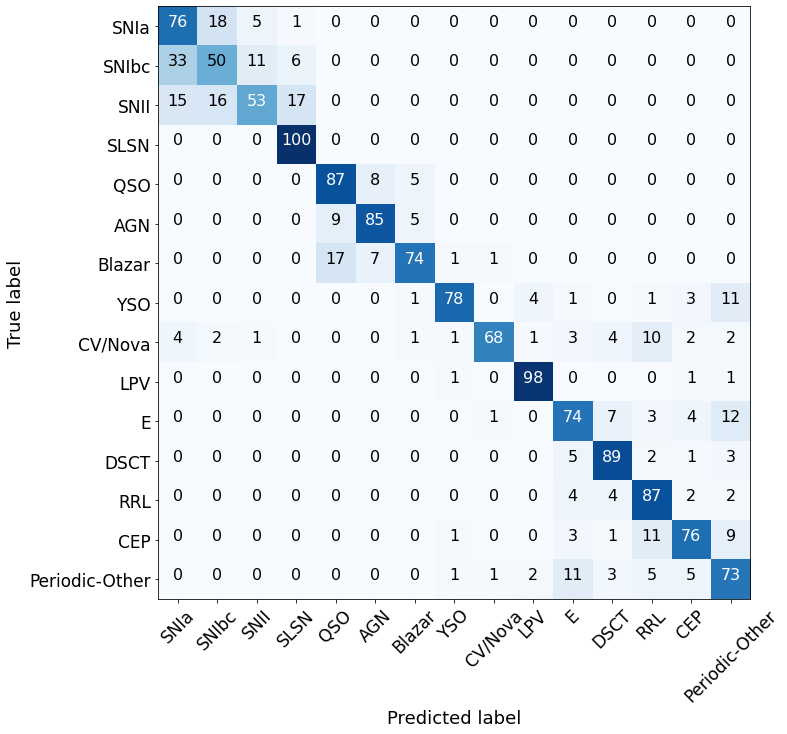

In [48]:
def plot_confusion_matrix_4whitepaper(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    

    
plot_confusion_matrix_4whitepaper(np.median(array_cnf_matrix,axis=0),label_order,'../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_multiclass_4whitepaper_original_hierarchical_classes.pdf')

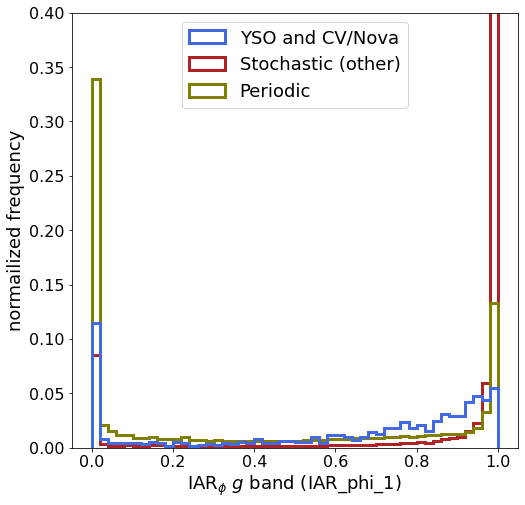

In [49]:
bins_hist = np.arange(0,1.01,0.02)

fi = plt.figure(figsize=(8,8))

weights = np.ones_like(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values)/float(len(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='YSO and CV/Nova', alpha=1.0)


weights = np.ones_like(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values)/float(len(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values,weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic (other)', alpha=1.0)

weights = np.ones_like(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Periodic') & (df_for_figures['class_original']!='QSO')].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Periodic'].values))  
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Periodic') & (df_for_figures['class_original']!='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic', alpha=1.0)

weights = np.ones_like(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values)/float(len(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue", alpha=1.0)



#weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values))
#binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='CV/Nova', alpha=1.0)


plt.ylim(0,0.4)

    
plt.legend(loc='upper center',fontsize=18)
plt.xlabel(r'IAR$_{\phi}$ $g$ band (IAR_phi_1)',fontsize=18)
plt.ylabel(r'normailized frequency',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/IAR_phi_1_CV_YSO.pdf',bbox_inches='tight')

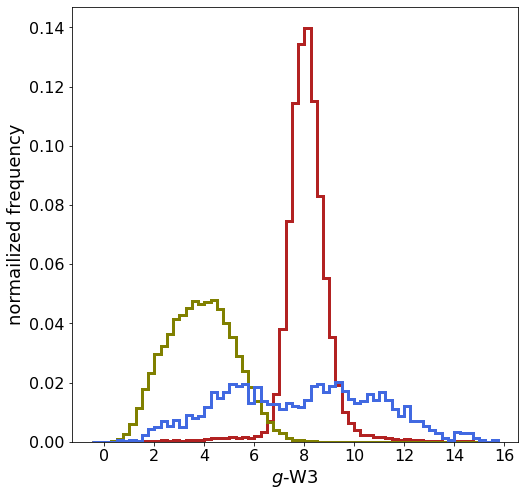

In [50]:
bins_hist = np.arange(-0.5,16,0.25)

fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values)/float(len(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values))
binss,hist,p = plt.hist(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values,weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic (other)', alpha=1.0)

weights = np.ones_like(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Periodic') & (df_for_figures['class_original']!='LPV')].values)/float(len(df_for_figures['g-W3'][df_for_figures['class_hierachical']=='Periodic'].values))  
binss,hist,p = plt.hist(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Periodic') & (df_for_figures['class_original']!='LPV')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic (not LPV)', alpha=1.0)

weights = np.ones_like(df_for_figures['g-W3'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values)/float(len(df_for_figures['g-W3'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values))
binss,hist,p = plt.hist(df_for_figures['g-W3'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='YSO and CV/Nova', alpha=1.0)

#weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values))
#binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='CV/Nova', alpha=1.0)


#plt.ylim(0,0.3)

    
#plt.legend(loc='upper left',fontsize=15)
plt.xlabel(r'$g$-W3',fontsize=18)
plt.ylabel(r'normailized frequency',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/g_W3_1_CV_YSO.pdf',bbox_inches='tight')